In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd
from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import importlib as il
from tqdm import tqdm
import math
import fast_time_interp

import pyIGRF as pyigrf
import apexpy
from apexpy import Apex

from scipy.signal import butter, sosfiltfilt, sosfilt_zi, sosfilt, lfilter, filtfilt, savgol_filter, wiener, order_filter
from numpy.polynomial import Chebyshev


In [2]:
# sat1 to sat3 are quiet time passes and sat4 to sar6 are storm time passes

path = 'time_interpolated_data/'

#file_path =['time_interpolated_data/1_quiet_0020_sat_pass.nc', 'time_interpolated_data/2_quiet_0202_sat_pass.nc', 'time_interpolated_data/3_quiet_0344_sat_pass.nc', 'time_interpolated_data/4_storm_1539_sat_pass.nc', 'time_interpolated_data/5_storm_1719_sat_pass.nc', 'time_interpolated_data/6_storm_1901_sat_pass.nc']
sat = []
names = []

for j in ['_F16', '_F17', '_F18']:
    for i in range(14):
        file = path + str(i) + j + '_passing.nc'
        name = str(i) + j + '_passing'
        names.append(name)
        sat_t = xr.open_dataset(file)
        sat.append(sat_t)

sat1 = sat[0]
sat2 = sat[1]
sat3 = sat[2]
sat4 = sat[9]
sat5 = sat[10]
sat6 = sat[11]
sat_new = [sat1, sat2, sat3, sat4, sat5, sat6]

#print(names)
sat6


<xarray.Dataset>
Dimensions:        (sat_step: 1697, sami_time: 596)
Coordinates:
    glat           (sat_step) float64 ...
    glon           (sat_step) float64 ...
    alt            (sat_step) float64 ...
    sat_time       (sat_step) datetime64[ns] ...
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    interpd_edens  (sat_step) float64 ...
    mlat           (sat_step) float64 ...
    mlon           (sat_step) float64 ...
    edens          (sami_time, sat_step) float64 ...

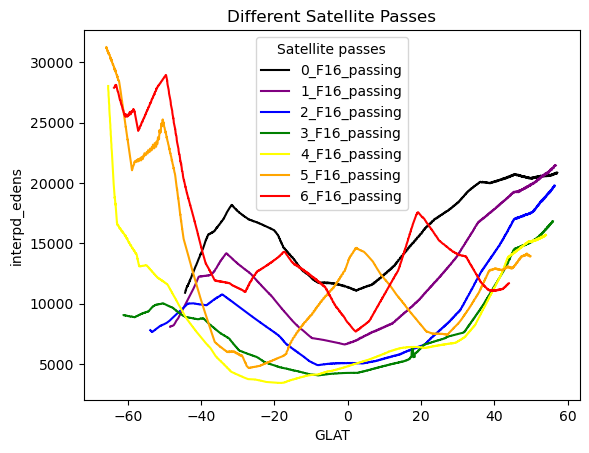

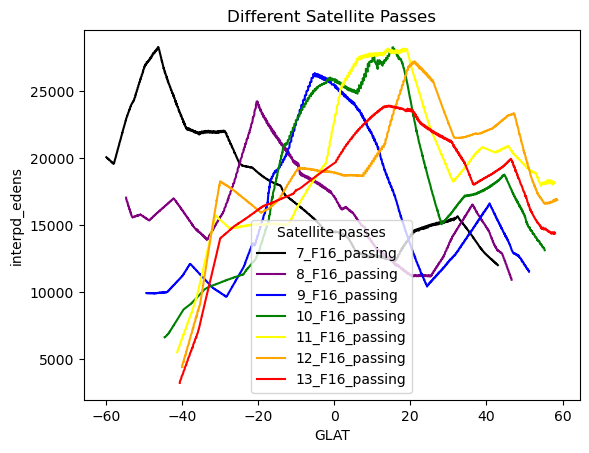

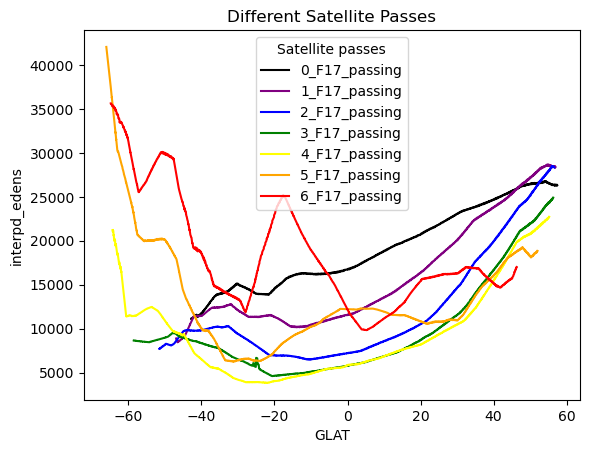

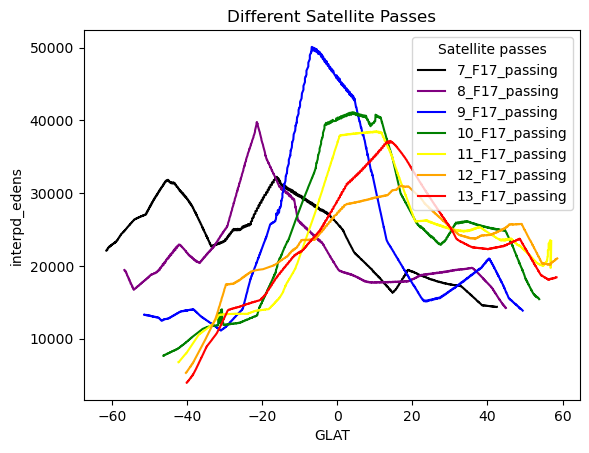

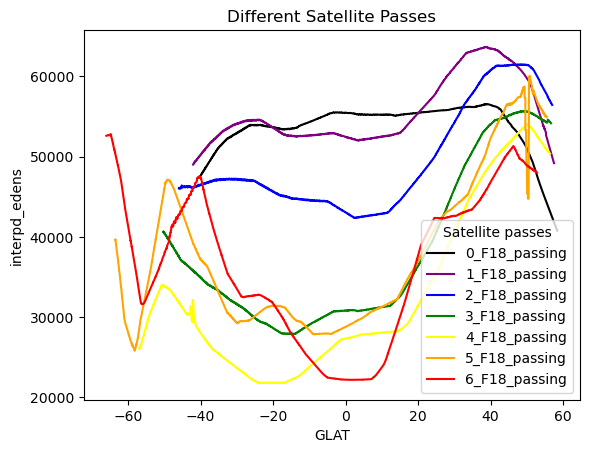

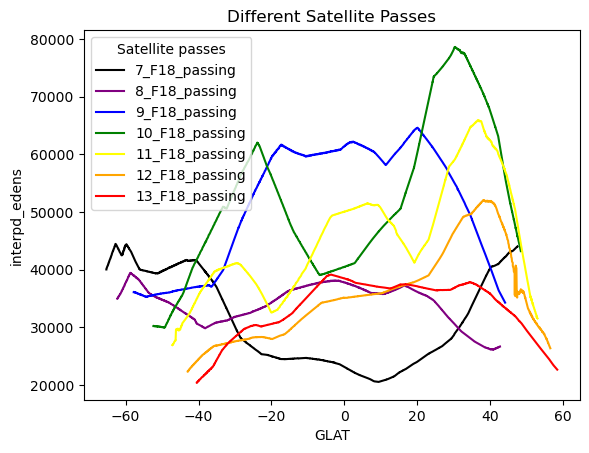

In [3]:
# Plotting for comparison of different satellite passes

fast_time_interp = il.reload(fast_time_interp)

fast_time_interp.plot_edens(sat, names, 'interpd_edens')


In [21]:
temp_data = 'temp/artificial_data/F16_2013_75-77_bandpassed'

time = []
raw = []
perturb = []
first = True

with open(temp_data, 'r') as file:
    for line in file:
        if first:
            first = False
            continue
        values = line.split(',')
        t, r, p = values
        time.append(datetime.strptime(t, '%Y-%m-%d %H:%M:%S'))
        raw.append(float(r))
        perturb.append(float(p))

# To remove the data of 16th March
raw = raw[86175:]
perturb = perturb[86175:]
time = time[86175:]

steps = np.arange(1, len(raw)+1)

data = {
    'time':time,
    'raw':raw,
    'prtb':perturb
}

df = pd.DataFrame(data)
df

,time,raw,prtb
0,2013-03-17 00:00:00,47031.445940,-7.195123
1,2013-03-17 00:00:01,47029.312565,-9.327579
2,2013-03-17 00:00:02,47034.259120,-9.398711
3,2013-03-17 00:00:03,47042.088359,-6.427891
4,2013-03-17 00:00:04,47078.266370,-2.547892
...,...,...,...
91844,2013-03-18 01:34:55,53200.153595,-10.748730
91845,2013-03-18 01:34:56,53198.039073,-28.128698
91846,2013-03-18 01:34:57,53410.451220,-36.256481
91847,2013-03-18 01:34:58,53404.000369,-28.971549


<xarray.DataArray 'interpd_edens' ()>
[1 values with dtype=float64]
Coordinates:
    glat      float64 ...
    glon      float64 ...
    alt       float64 ...
    sat_time  datetime64[ns] ... 47182.879870714234


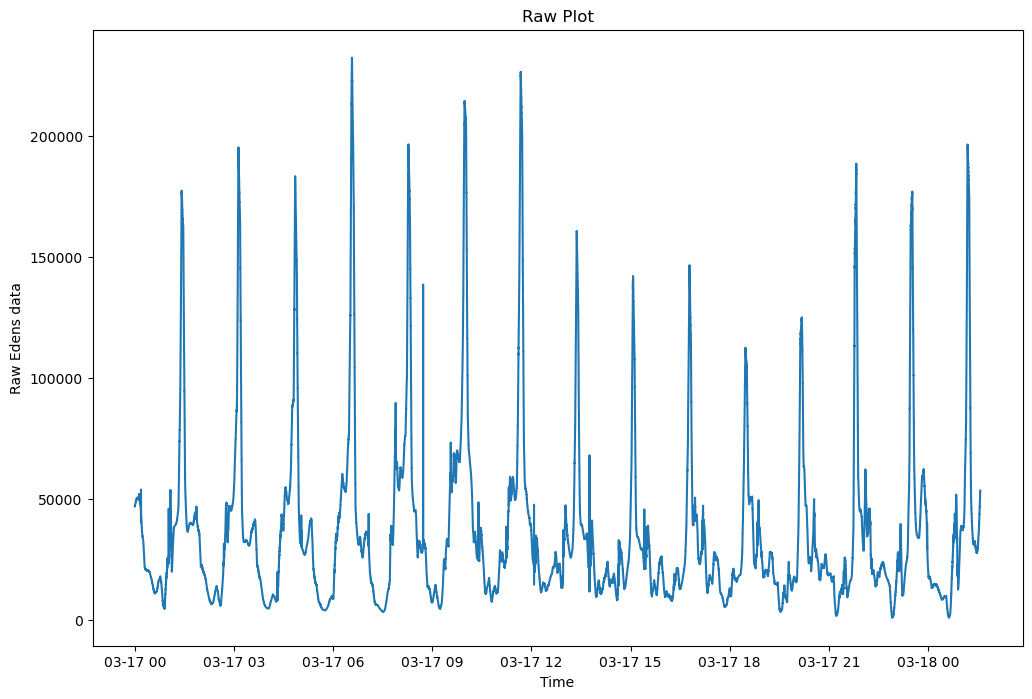

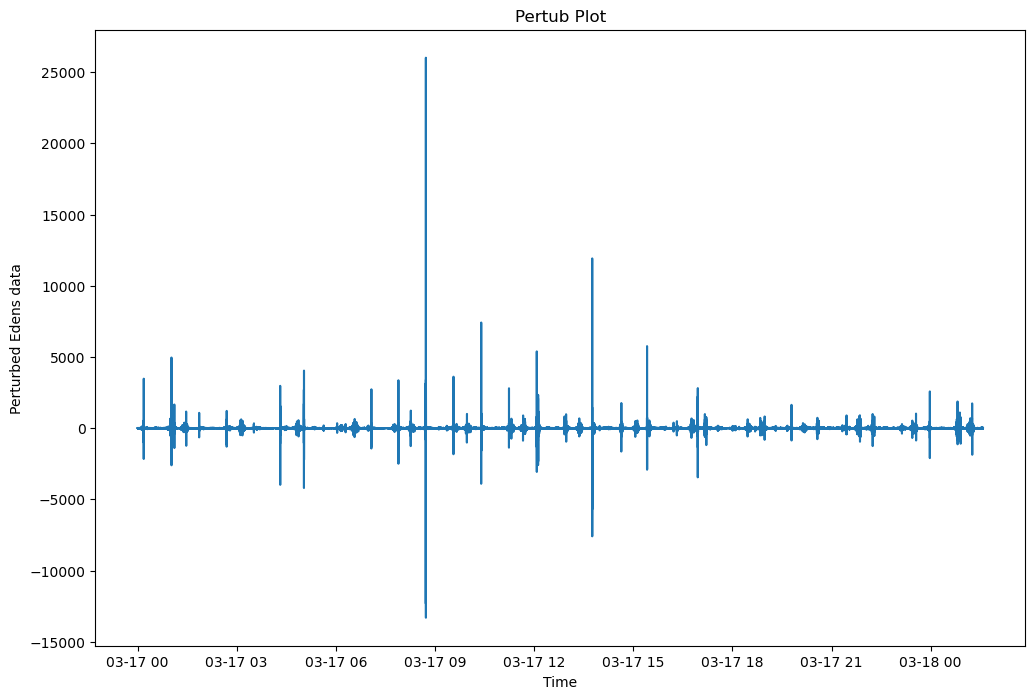

In [22]:
smth = np.zeros(len(time))

for i in range(len(smth)):
    smth[i] = data['raw'][i] - data['prtb'][i]

satdf = xr.open_dataset('time_interpolated_data/sat_data_day_17.nc')
print(satdf['interpd_edens'][10], raw[10])

plt.figure(figsize=(12,8))
plt.plot(data['time'],raw)
plt.ylabel('Raw Edens data')
plt.xlabel('Time')
plt.title('Raw Plot')
plt.show()

plt.figure(figsize=(12,8))
plt.plot(data['time'],perturb)
plt.ylabel('Perturbed Edens data')
plt.xlabel('Time')
plt.title('Pertub Plot')
plt.show()

'''
plt.figure(figsize=(12,8))
plt.plot(data['time'],smth)
plt.ylabel('Smoothened Edens data')
plt.xlabel('Time')
plt.title('(Raw - Pertub) Plot')
plt.show()
''';

Range of time in seconds = 92099.0
Sample Rate = 1.002721858702871
lower limit = 0.00020833333333333335 , upper limit = 0.00037037037037037035
31319 23611
4189.442150971796 -10527.118491462088


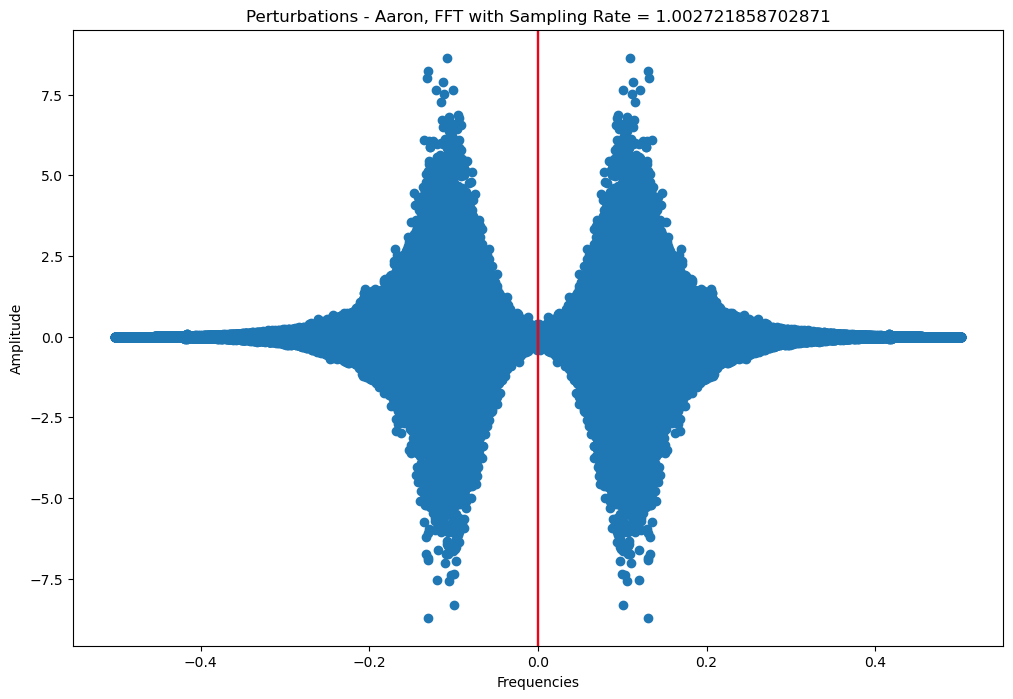

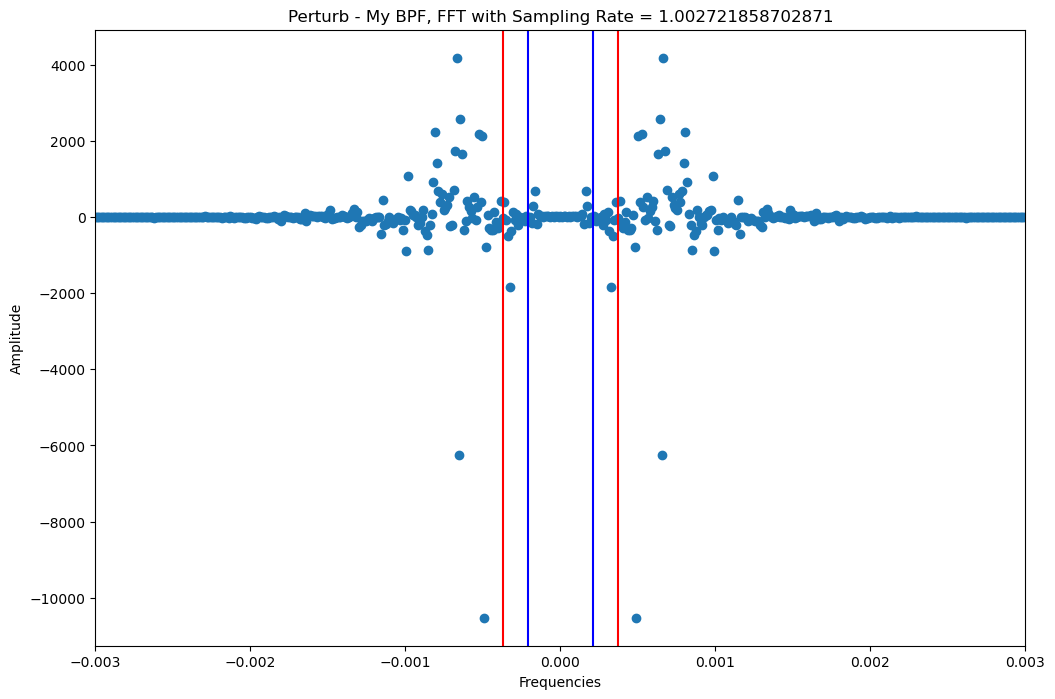

72349.1926348595 -12416.698948943023


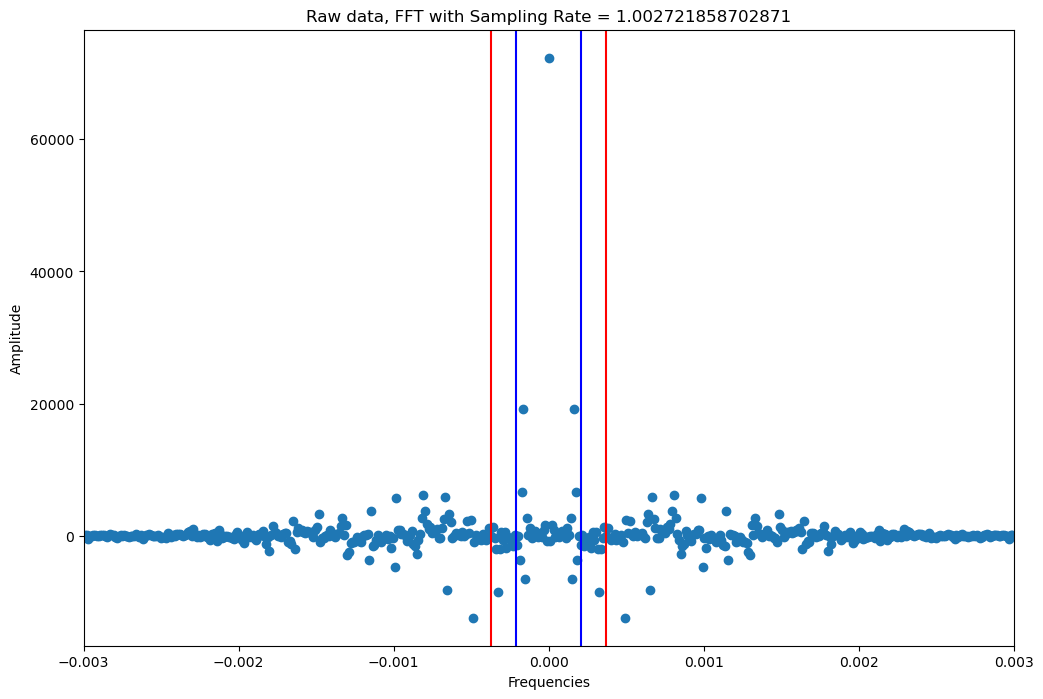

In [59]:
import filter_self
filter_self = il.reload(filter_self)

time_dif = (time[-1] - time[0]).total_seconds()
print('Range of time in seconds =', time_dif)
sample_rate = 1*time_dif/len(raw) # should always be this value as it is linked to number of points in range
print('Sample Rate =', sample_rate)

'''
n = len(raw)
fs = 1
duration = len(raw)
freq = 1/200
time_t = np.linspace(0,duration,n)
test = 4 + 7*np.sin(2*np.pi*freq*time_t)
'''

## Putting the bandpass filter from [0.00333,0.006667] frequency
limits = [45*60,80*60]
final, finalperc = filter_self.filt_filt(raw, sample_rate, lims=limits, order=1, xarray=False)
#final2, finalperc2 = filter_self.filt_filt(test, fs, lims=limits, order=2)
#print(final)

'''
# providing no information as such
plt.figure(figsize=(12,8))
plt.plot(data['time'][:], final[:])
plt.xlabel('Time')
plt.ylabel('Filtered Value')
plt.title('Band Pass Filter Result')
plt.xlim()
#plt.ylim(-20000,30000)

plt.figure(figsize=(12,8))
plt.plot(data['time'][:],perturb[:])
plt.ylabel('Perturbed Edens data')
plt.xlabel('Time')
plt.title('Pertub Plot')
#plt.ylim(-20000,30000)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(data['time'][:],(perturb - final)[:])
plt.ylabel('Perturbed Edens data')
plt.xlabel('Time')
plt.title('Difference (Perturb - My_result)')
#plt.ylim(-20000,30000)
plt.show()
'''

fft_input = perturb
fourier, freq = filter_self.FFT(fft_input, sample_rate)

plt.figure(figsize=(12,8))
plt.scatter(freq, fourier.real)
#plt.ylim(-1000000,1000000)
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
plt.title('Perturbations - Aaron, FFT with Sampling Rate = ' + str(sample_rate))
plt.axvline(x = (1/limits[1]), color = 'b', label = 'Lower limit')
plt.axvline(x = -(1/limits[1]), color = 'b', label = 'Lower limit')
plt.axvline(x = (1/limits[0]), color = 'r', label = 'Upper limit')
plt.axvline(x = -(1/limits[0]), color = 'r', label = 'Upper limit')

print(np.argmax(perturb), np.argmax(final))


fft_input_1 = final
fourier_1, freq_1 = filter_self.FFT(fft_input_1, sample_rate)

print(np.max(fourier_1.real), min(fourier_1.real))

plt.figure(figsize=(12,8))
plt.scatter(freq_1, fourier_1.real)
#plt.ylim(-6000000,6000000)
plt.xlim(-1,1)
plt.xlim(-0.003, 0.003)
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
#plt.ylim(-150,150)
plt.title('Perturb - My BPF, FFT with Sampling Rate = ' + str(sample_rate))
plt.axvline(x = (1/limits[1]), color = 'b', label = 'Lower limit')
plt.axvline(x = -(1/limits[1]), color = 'b', label = 'Lower limit')
plt.axvline(x = (1/limits[0]), color = 'r', label = 'Upper limit')
plt.axvline(x = -(1/limits[0]), color = 'r', label = 'Upper limit')
plt.show()


fft_input_2 = raw
fourier_2, freq_2 = filter_self.FFT(fft_input_2, sample_rate)
print(np.max(fourier_2.real), min(fourier_2.real))

plt.figure(figsize=(12,8))
plt.scatter(freq_2, fourier_2.real)
#plt.ylim(-6000000,6000000)
plt.xlim(-0.003, 0.003)
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
#plt.ylim(-150,150)
plt.title('Raw data, FFT with Sampling Rate = ' + str(sample_rate))
plt.axvline(x = (1/limits[1]), color = 'b', label = 'Lower limit')
plt.axvline(x = -(1/limits[1]), color = 'b', label = 'Lower limit')
plt.axvline(x = (1/limits[0]), color = 'r', label = 'Upper limit')
plt.axvline(x = -(1/limits[0]), color = 'r', label = 'Upper limit')
plt.show()


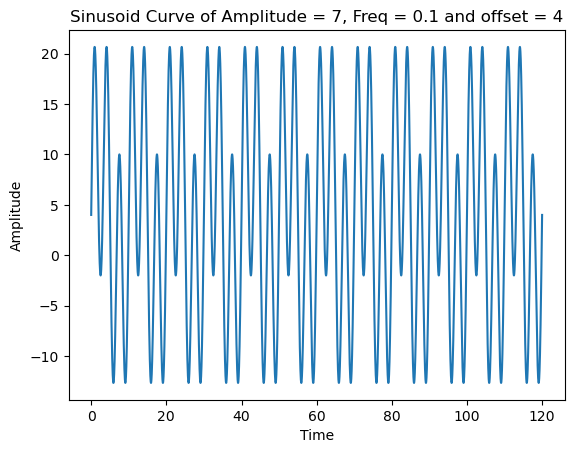

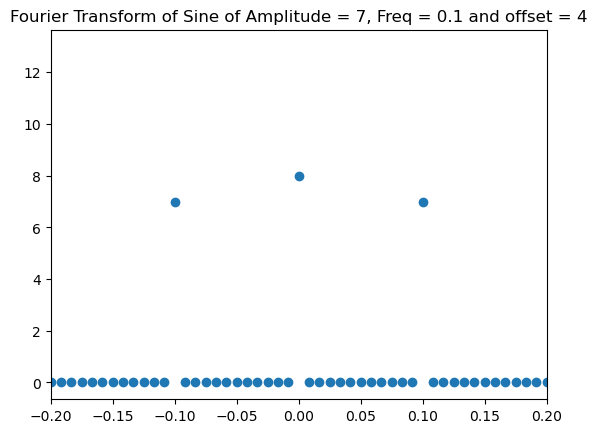

0 23963
lower 0.0075 upper 0.15
2 23971


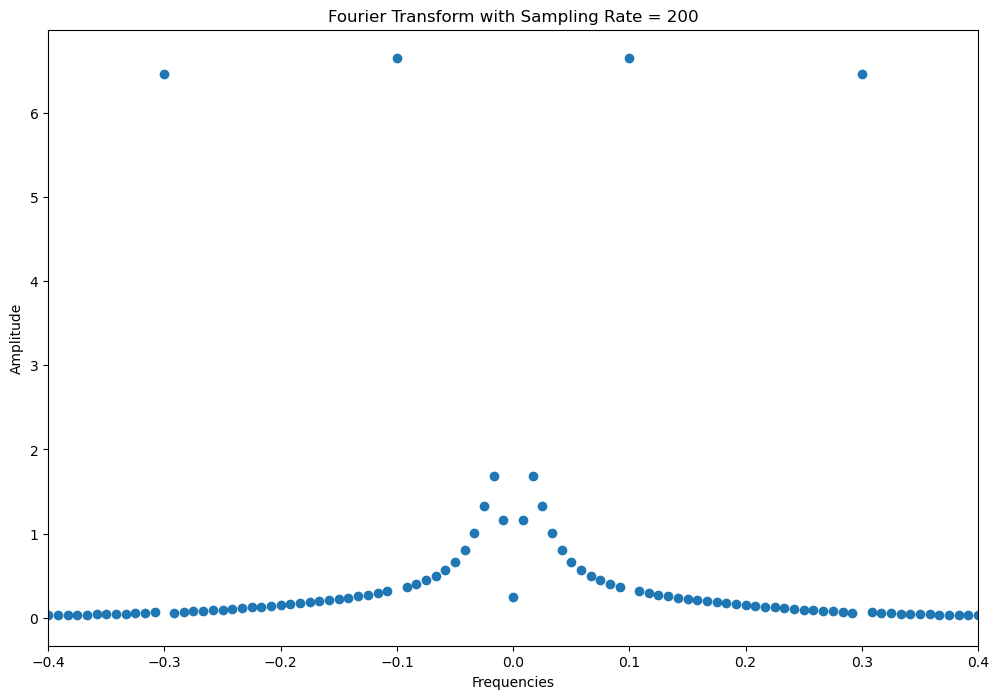

[ 5.13626507e+00  5.18471423e+00  5.23320023e+00 ... -1.86995243e-03
 -1.57532096e-03 -1.31158891e-03]


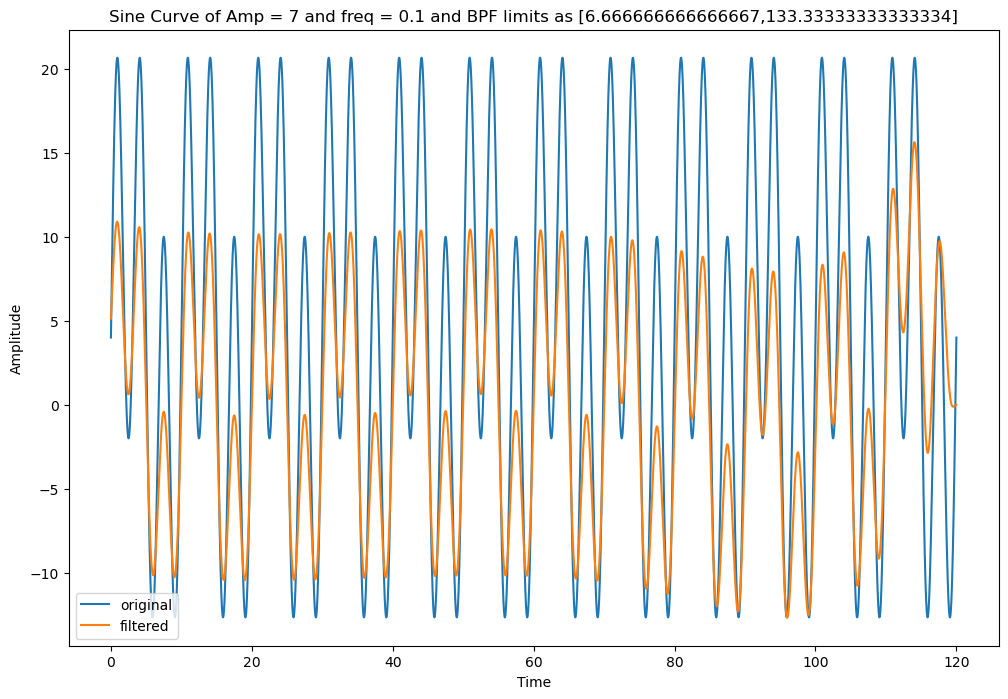

In [22]:
# EXAMPLES for verifying BPF and FFT Techniques
# SKIP

import filter_self
filter_self = il.reload(filter_self)


# Example for FFT function

# Initialization
fs = 200
duration = 120
n = duration*fs
time_t = np.linspace(0,duration,n)
freq = 0.1
ys = 4 + 7*np.sin(2*np.pi*freq*time_t) + 13*np.sin(2*np.pi*3*freq*time_t) #+ np.sin(2*np.pi*0.015*time) + np.sin(2*np.pi*0.008*time)
plt.plot(time_t,ys)
plt.title('Sinusoid Curve of Amplitude = 7, Freq = ' + str(freq) + ' and offset = 4')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Function
ff, freq_axis = filter_self.FFT(ys, fs)

plt.scatter(freq_axis, abs(ff))
plt.xlim(-0.2,0.2)
plt.title('Fourier Transform of Sine of Amplitude = 7, Freq = ' + str(freq) + ' and offset = 4')
plt.show()
print(np.argmax(ff), np.argmin(ff))

# END


# Applying BPF and then doing FFT and Seeing Attenuation

limits = [1/0.15, 1/0.0075]
ysf, ysf_perc = filter_self.filt_filt(ys, sampling_freq=fs, lims=limits, order=2)
ff2, freq_axis2 = filter_self.FFT(ysf, fs)
print(np.argmax(ff2), np.argmin(ff2))

plt.figure(figsize=(12,8))
plt.scatter(freq_axis2, abs(ff2))
#plt.ylim(-1000000,1000000)
plt.xlim(-0.4,0.4)
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
plt.title('Fourier Transform with Sampling Rate = ' + str(fs))
plt.show()

print(ysf)
plt.figure(figsize=(12,8))
plt.plot(time_t, ys, label='original')
plt.plot(time_t, ysf, label='filtered')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sine Curve of Amp = 7 and freq = ' + str(freq) + ' and BPF limits as [' + str(limits[0]) + ',' + str(limits[1]) + ']')
plt.legend()
#print(freq_axis2[np.argmin(fourier.real)])
#print(freq_axis2[np.argmax(fourier.real)])
#print(np.max(ysf[200:300]))


In [52]:
sami_regrid1 = xr.open_dataset('/petastore/phil/DMSP_INTERPOLATIONS/interpolated/20130317/GLOBAL_SAMI_REGRID.nc')

#sami_regrid = sami_regrid.where((sami_regrid.time.dt.day.values == 17), drop='True')
sami_regrid = sami_regrid1.isel(time=slice(288,-19))

print(sami_regrid['time'][0].values, sami_regrid['time'][1].values)
print(len(sami_regrid['time']))
print(((sami_regrid['time'][-1] - sami_regrid['time'][0]).values))
print(86400000000000/1e9)
fs = len(sami_regrid['time'])/(86400000000000/1e9)
print('Sampling frequency, fs =', fs)

sami_regrid


#288 to -21

2013-03-17T00:00:00.000000000 2013-03-17T00:05:00.000000000
289
86400000000000 nanoseconds
86400.0
Sampling frequency, fs = 0.0033449074074074076


<xarray.Dataset>
Dimensions:  (time: 289, alt: 42, lat: 180, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-17 2013-03-17T00:05:00 ... 2013-03-18
  * alt      (alt) int64 150 200 250 300 350 400 ... 2000 2050 2100 2150 2200
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
Data variables:
    edens    (time, lon, lat, alt) float64 ...

enter the pass num =  37


241.56875712656785 255.3 225.3
44.1 -57.8
346557.1449494048 0.0
lower limit = 0.000196078431372549 , upper limit = 0.00037037037037037035
lower limit = 0.000196078431372549 , upper limit = 0.00037037037037037035


Text(0.5, 1.0, 'lon = 241.56875712656785')

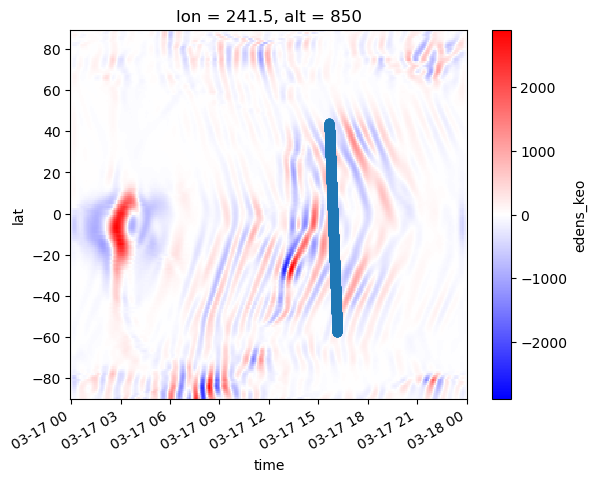

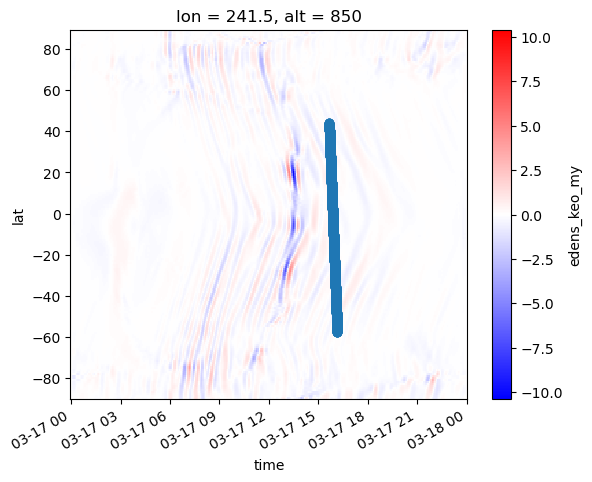

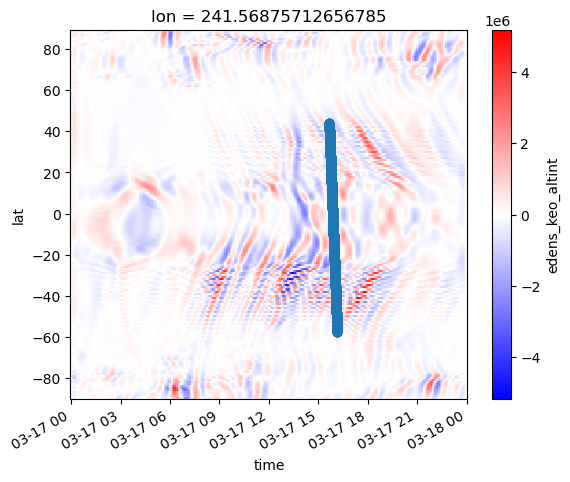

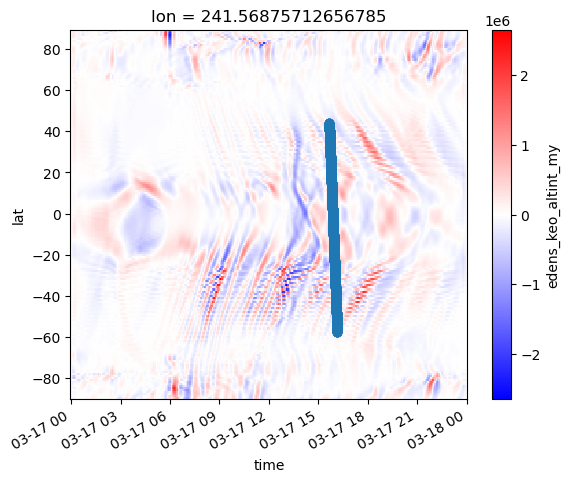

In [94]:
pass_num = int(input('enter the pass num = '))
sat_pass = sat[pass_num]
alt = 850
glon_avg = sat_pass.glon.values.mean()
print(glon_avg, np.max(sat_pass.glon.values), np.min(sat_pass.glon.values))
print(np.max(sat_pass.glat.values), np.min(sat_pass.glat.values))
print(np.max(sat_pass.edens.values), np.min(sat_pass.edens.values))
filter_self = il.reload(filter_self)




keo = filter_self.ab_filt_filt(sami_regrid.edens.sel(alt = alt, lon=glon_avg, method='nearest'), freq = 5, percent=False)
keo_alt_int = filter_self.ab_filt_filt(sami_regrid.edens.sel(lon=glon_avg, method='nearest').integrate('alt'), percent=False)
sami_regrid['edens_keo'] = (('time', 'lat'), keo)
sami_regrid['edens_keo_altint'] = (('time','lat'), keo_alt_int)

#print(sami_regrid.edens.sel(alt=alt, lon = glon_avg, method='nearest').values)
#plt.plot()

keo, keo_perc = filter_self.filt_filt(sami_regrid.edens.sel(alt = alt, lon=glon_avg, method='nearest'), sampling_freq = fs, lims=[45*60, 85*60], order=1)
keo_alt_int, keo2_perc = filter_self.filt_filt(sami_regrid.edens.sel(lon=glon_avg, method='nearest').integrate('alt'), sampling_freq = fs, lims=[45*60, 85*60], order=1)
sami_regrid['edens_keo_my'] = (('time', 'lat'), keo_perc)
sami_regrid['edens_keo_altint_my'] = (('time','lat'), keo_alt_int)
#print(sami_regrid)


plt.figure()
sami_regrid['edens_keo'].plot(x='time', cmap='bwr')
plt.scatter(sat_pass.sat_time, sat_pass.glat)
plt.title('lon = ' + str(glon_avg)[:5] + ', alt = ' + str(alt))

plt.figure()
sami_regrid['edens_keo_my'].plot(x='time', cmap='bwr')
plt.scatter(sat_pass.sat_time, sat_pass.glat)
plt.title('lon = ' + str(glon_avg)[:5] + ', alt = ' + str(alt))

plt.figure()
sami_regrid['edens_keo_altint'].plot(x='time', cmap='bwr')
plt.scatter(sat_pass.sat_time, sat_pass.glat)
plt.title('lon = ' + str(glon_avg))

plt.figure()
sami_regrid['edens_keo_altint_my'].plot(x='time', cmap='bwr')
plt.scatter(sat_pass.sat_time, sat_pass.glat)
plt.title('lon = ' + str(glon_avg))

<xarray.Dataset>
Dimensions:        (sat_step: 1780, sami_time: 596)
Coordinates:
    glat           (sat_step) float64 62.9 62.8 62.8 62.7 ... -40.8 -40.8 -40.9
    glon           (sat_step) float64 173.7 173.6 173.6 ... 141.6 141.6 141.6
    alt            (sat_step) float64 ...
    sat_time       (sat_step) datetime64[ns] 2013-03-17T19:00:19 ... 2013-03-...
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    interpd_edens  (sat_step) float64 2.036e+04 2.025e+04 ... 5.808e+03
    edens          (sami_time, sat_step) float64 ...


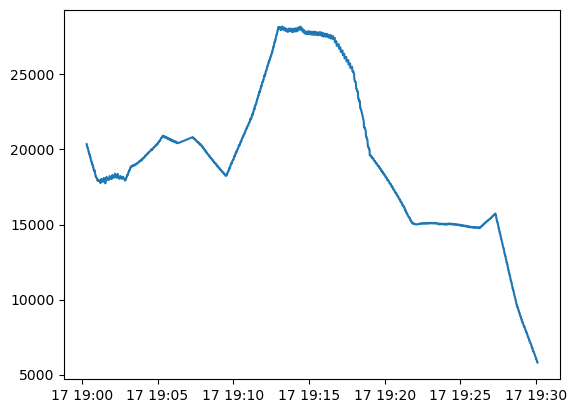

In [11]:
# Analyzing the Satellite Where TIDs are Present
sat_tid = [sat[6], sat[20], sat[34]]
sat_name = ['F16', 'F17', 'F18']


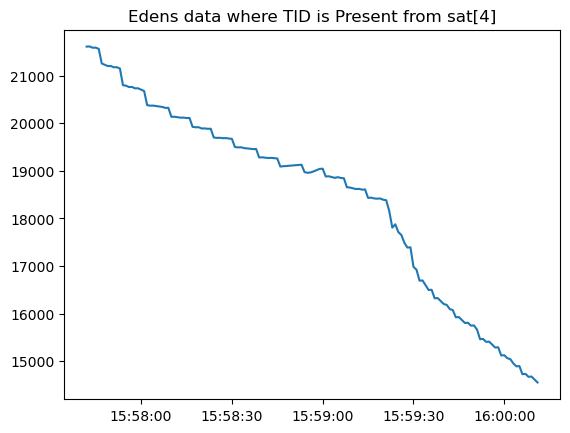

new 149000000000 nanoseconds
new <xarray.DataArray 'glat' ()>
array(-8.7)


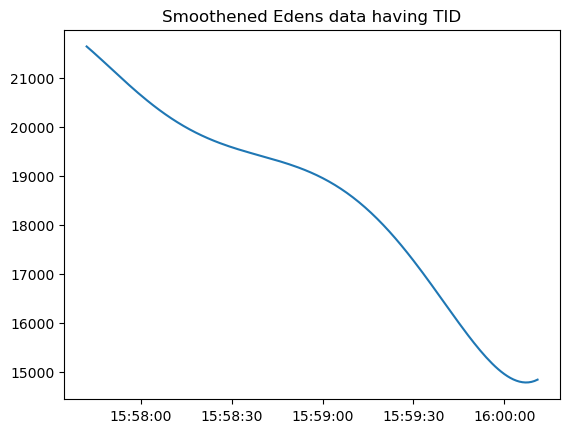

150 size
Range of time in seconds = 150
Sample Rate = 1.0


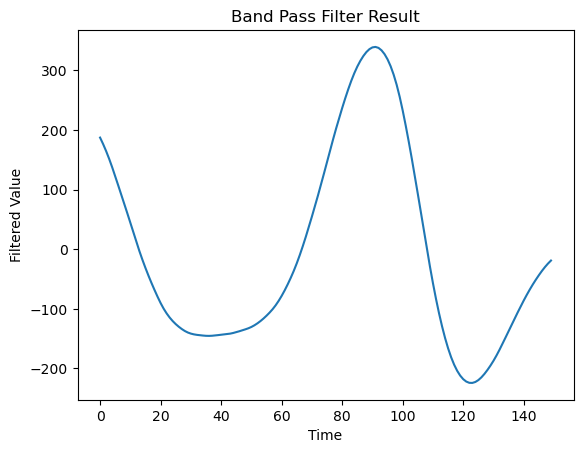

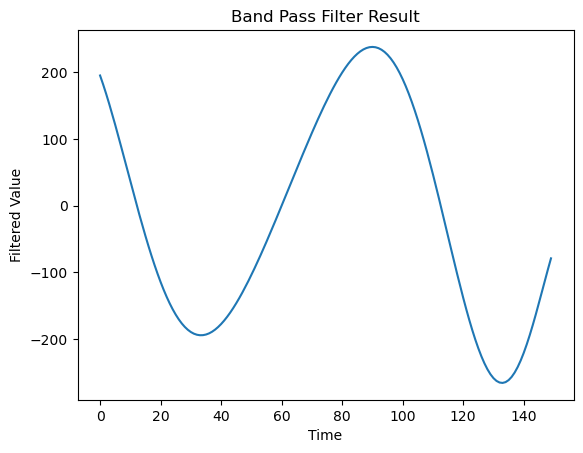

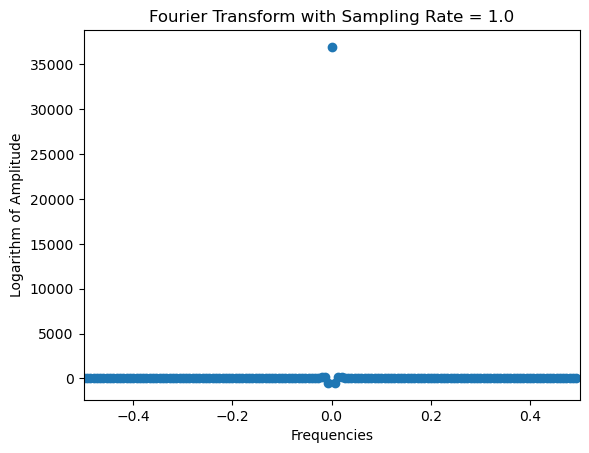

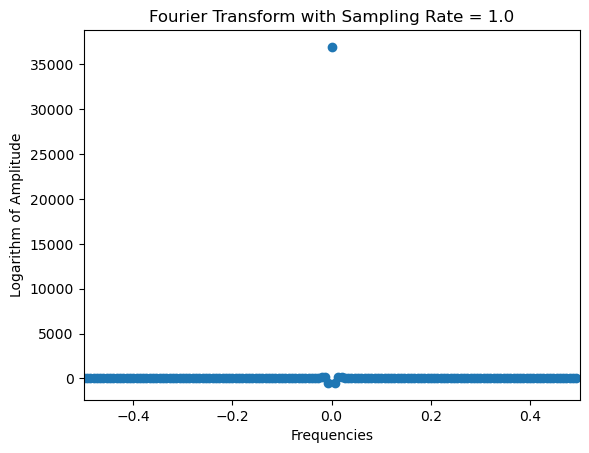

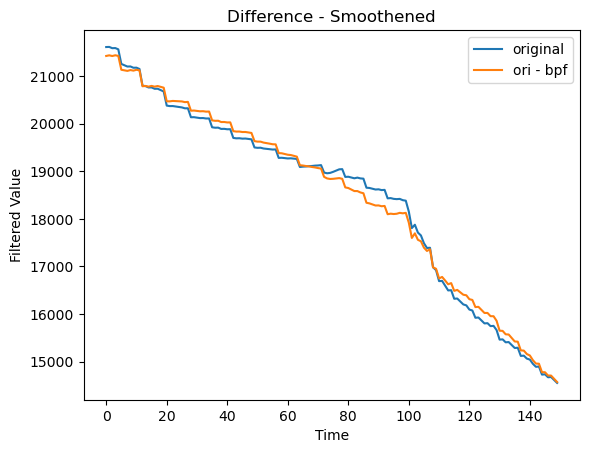

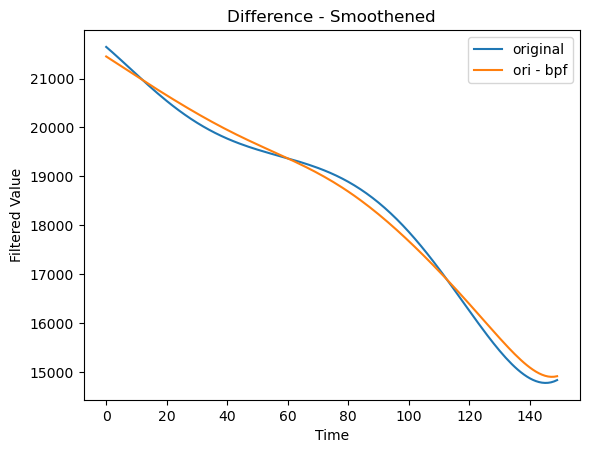

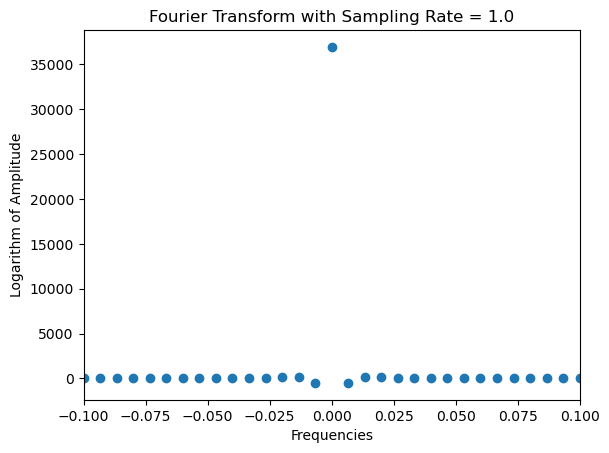

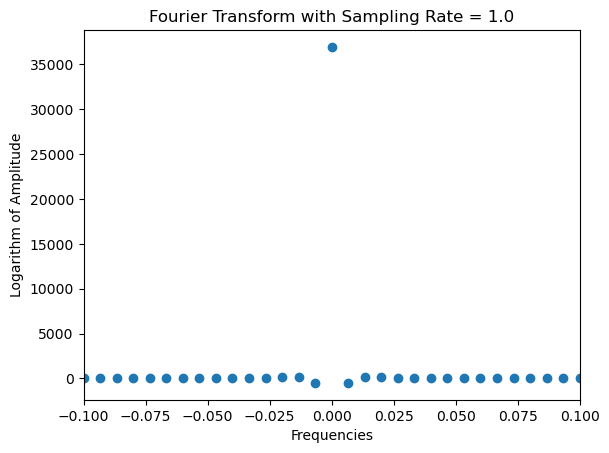

In [9]:
sat[3] = sat4

sat[3] = sat[3].isel(sat_step=slice(1150,1300))
#print(sat[3])
plt.plot(sat[3]['sat_time'], sat[3]['interpd_edens'])
plt.title('Edens data where TID is Present from sat[4]')
plt.show()

y =  sat[3]['interpd_edens']
c = Chebyshev.fit(sat[3]['sat_step'], y, 5)
yf = c(sat[3]['sat_step'])
print('new',(sat[3]['sat_time'][-1] - sat[3]['sat_time'][0]).values)
print('new',(sat[3]['glat'][-1] - sat[3]['glat'][0]))
plt.plot(sat[3]['sat_time'],yf)
plt.title('Smoothened Edens data having TID')
plt.show()




import filter_self
filter_self = il.reload(filter_self)

time_dif = 150 # seconds
n = len(sat[3]['interpd_edens'])
print(n, 'size')
fs = n/time_dif
print('Range of time in seconds =', time_dif)
print('Sample Rate =', fs)
limits = [0.005, 0.01]
final = filter_self.filt_filt(y.values, sampling_freq = fs, lims = limits) #sat[3]['interpd_edens'])
final2 = filter_self.filt_filt(yf.values, sampling_freq = fs, lims = limits) #sat[3]['interpd_edens'])
#print(final)

#plt.figure(figsize=(12,8))
plt.plot(final)
plt.xlabel('Time')
plt.ylabel('Filtered Value')
plt.title('Band Pass Filter Result')
plt.xlim()
plt.show()

#plt.figure(figsize=(12,8))
plt.plot(final2)
plt.xlabel('Time')
plt.ylabel('Filtered Value')
plt.title('Band Pass Filter Result')
plt.xlim()
plt.show()


fourier_or, freq_or = filter_self.FFT(y.values, fs)
fourier2_or, freq2_or = filter_self.FFT(yf.values, fs)

#plt.figure(figsize=(12,8))
plt.scatter(freq_or, fourier_or.real)
#plt.ylim(-10000,10000)
plt.xlim(-0.5, 0.5)
plt.xlabel('Frequencies')
plt.ylabel('Logarithm of Amplitude')
plt.title('Fourier Transform with Sampling Rate = ' + str(fs))
plt.show()

#plt.figure(figsize=(12,8))
plt.scatter(freq2_or, fourier2_or.real)
#plt.ylim(-10000,10000)
plt.xlim(-0.5, 0.5)
plt.xlabel('Frequencies')
plt.ylabel('Logarithm of Amplitude')
plt.title('Fourier Transform with Sampling Rate = ' + str(fs))
plt.show()

#plt.figure(figsize=(12,8))
plt.plot(y.values, label='original')
plt.plot(y.values - final, label='ori - bpf')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Filtered Value')
plt.title('Difference - Smoothened')
plt.xlim()
plt.show()

#plt.figure(figsize=(12,8))
plt.plot(yf.values, label='original')
plt.plot(yf.values - final2, label='ori - bpf')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Filtered Value')
plt.title('Difference - Smoothened')
plt.xlim()
plt.show()


fourier, freq = filter_self.FFT(y.values, fs)
fourier2, freq2 = filter_self.FFT(yf.values, fs)

#plt.figure(figsize=(12,8))
plt.scatter(freq, fourier.real)
#plt.ylim(-10000,10000)
plt.xlim(-0.1, 0.1)
plt.xlabel('Frequencies')
plt.ylabel('Logarithm of Amplitude')
plt.title('Fourier Transform with Sampling Rate = ' + str(fs))
plt.show()

#plt.figure(figsize=(12,8))
plt.scatter(freq2, fourier2.real)
#plt.ylim(-10000,10000)
plt.xlim(-0.1, 0.1)
plt.xlabel('Frequencies')
plt.ylabel('Logarithm of Amplitude')
plt.title('Fourier Transform with Sampling Rate = ' + str(fs))
plt.show()



In [10]:
print(data['time'][86175])

2013-03-17 00:00:00


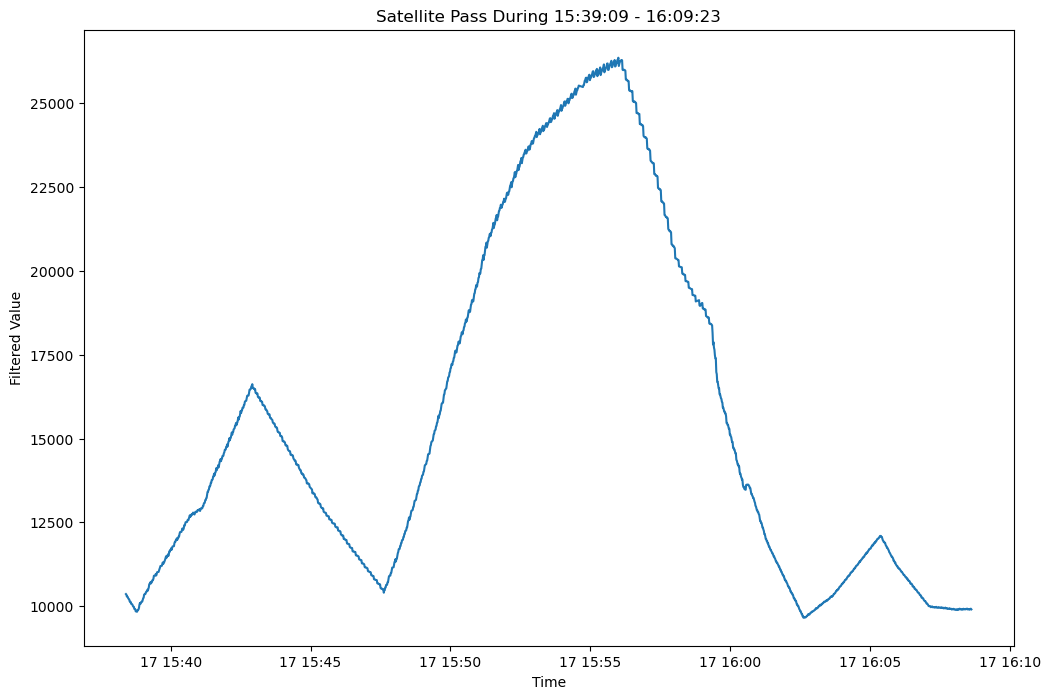

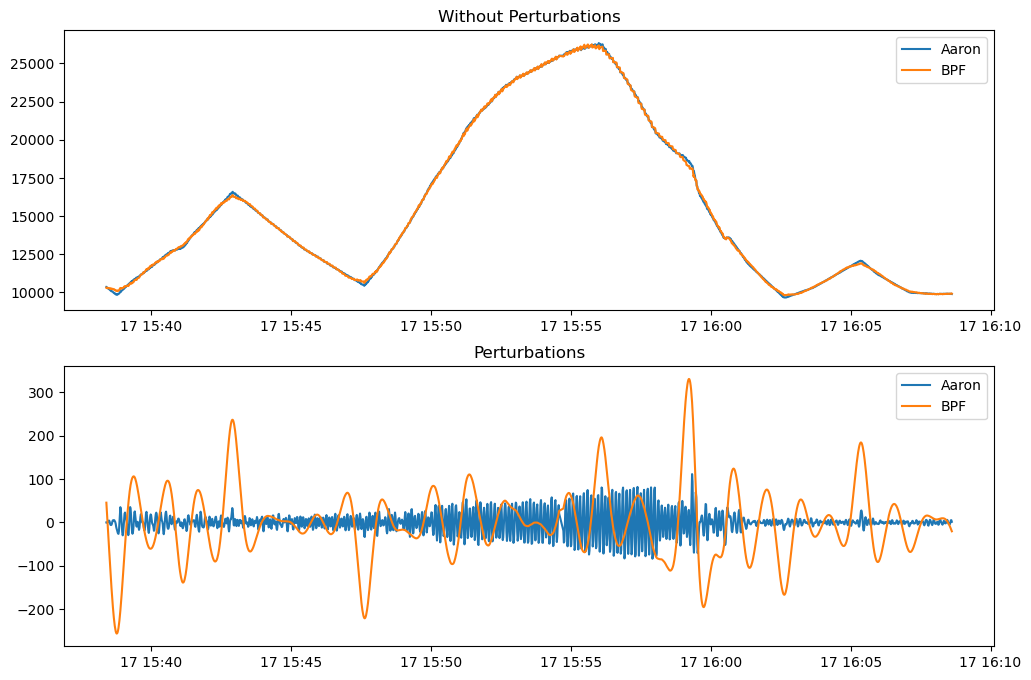

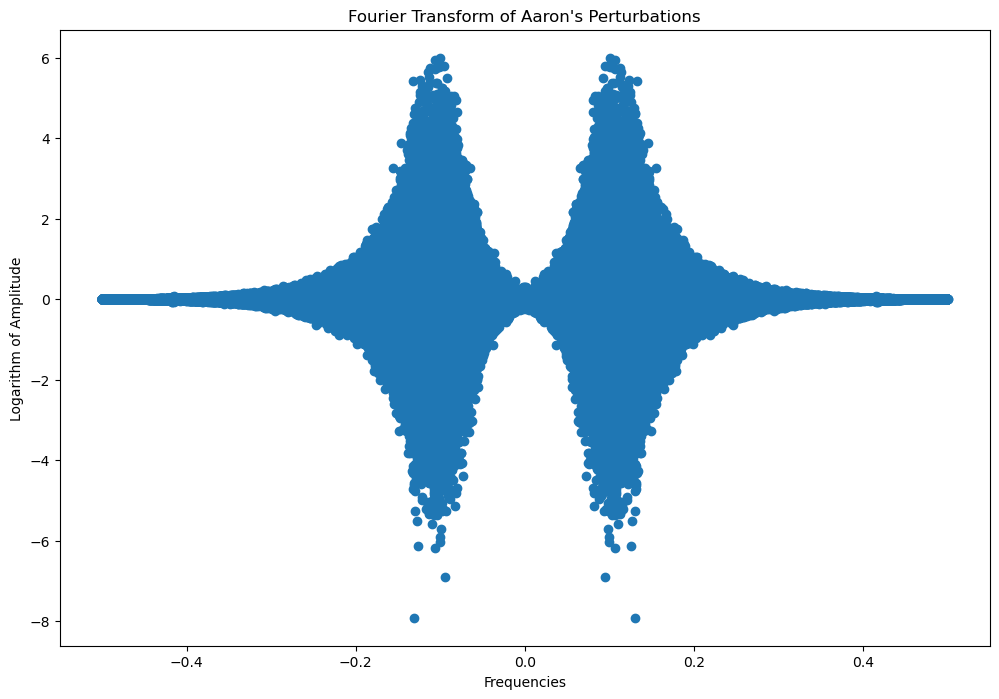

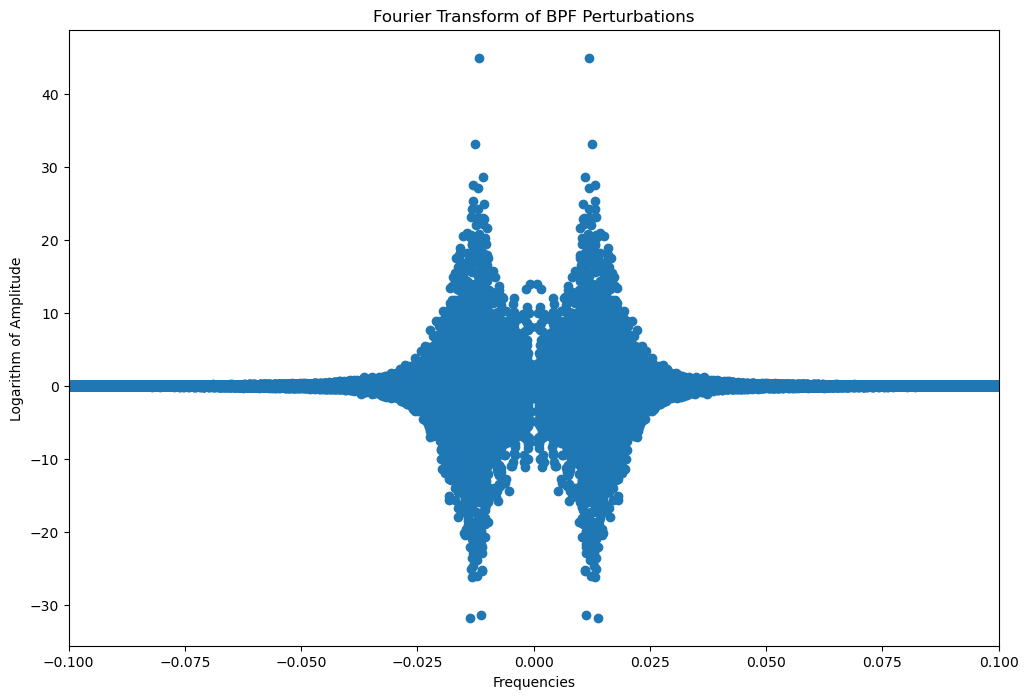

-0.011813013975643733 -0.011813013975643733


In [11]:
c = 86175
t = np.arange((56149+86175),(57955+86175))

limits = [0.005, 0.01]
perturb_filt = filter_self.filt_filt(raw, 1, lims=limits, percent=False)


#print(final)
plt.figure(figsize=(12,8))
plt.plot(data['time'][56149+c:57955+c], raw[56149+c:57955+c])
plt.xlabel('Time')
plt.ylabel('Filtered Value')
plt.title('Satellite Pass During 15:39:09 - 16:09:23')
plt.xlim()
#plt.ylim(-20000,30000)

'''
plt.figure(figsize=(12,8))
plt.plot(data['time'][56149+c:57955+c],perturb[56149+c:57955+c], label='Aaron')
plt.plot(data['time'][56149+c:57955+c],perturb_filt[56149+c:57955+c], label='BPF')
plt.legend()
plt.ylabel('Perturbed Edens data')
plt.xlabel('Time')
plt.title('Pertubations Plot')
#plt.ylim(-20000,30000)
plt.show()
'''

diff1 = np.zeros(len(perturb))
diff1_perc = np.zeros(len(perturb))
diff2 = np.zeros(len(perturb))
diff2_perc = np.zeros(len(perturb))

for i in range(len(perturb)):
    diff1[i] = raw[i] - perturb[i]
    diff1_perc[i] = abs(perturb[i])
    diff2[i] = raw[i] - perturb_filt[i]
    diff2_perc[i] = abs(perturb_filt[i])

'''
plt.figure(figsize=(12,8))
plt.plot(data['time'][56149+c:57955+c], diff1[56149+c:57955+c], label='Aaron')
plt.plot(data['time'][56149+c:57955+c], diff2[56149+c:57955+c], label='BPF')
plt.legend()
plt.title('Without Perturbations')
'''

fig, axs = plt.subplots(2,1, figsize=(12,8))
axs[0].plot(data['time'][56149+c:57955+c], diff1[56149+c:57955+c], label='Aaron')
axs[0].plot(data['time'][56149+c:57955+c], diff2[56149+c:57955+c], label='BPF')
axs[0].legend()
axs[0].set_title('Without Perturbations')

axs[1].plot(data['time'][56149+c:57955+c], perturb[56149+c:57955+c], label='Aaron')
axs[1].plot(data['time'][56149+c:57955+c], perturb_filt[56149+c:57955+c], label='BPF')
axs[1].legend()
axs[1].set_title('Perturbations')

fs = 1
ff_perturb, freq_perturb = filter_self.FFT(perturb, fs)
ff_perturb_filt, freq_perturb_filt = filter_self.FFT(perturb_filt, fs)

plt.figure(figsize=(12,8))
plt.scatter(freq_perturb, ff_perturb.real)
plt.xlabel('Frequencies')
plt.ylabel('Logarithm of Amplitude')
plt.title('Fourier Transform of Aaron\'s Perturbations')
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(freq_perturb_filt, ff_perturb_filt.real)
plt.xlabel('Frequencies')
plt.xlim(-0.1,0.1)
plt.ylabel('Logarithm of Amplitude')
plt.title('Fourier Transform of BPF Perturbations')
plt.show()

print(freq_perturb_filt[np.argmax(ff_perturb_filt)], freq_perturb_filt[np.argmax(ff_perturb_filt)])


(-0.034354166666666665, 0.0339375)

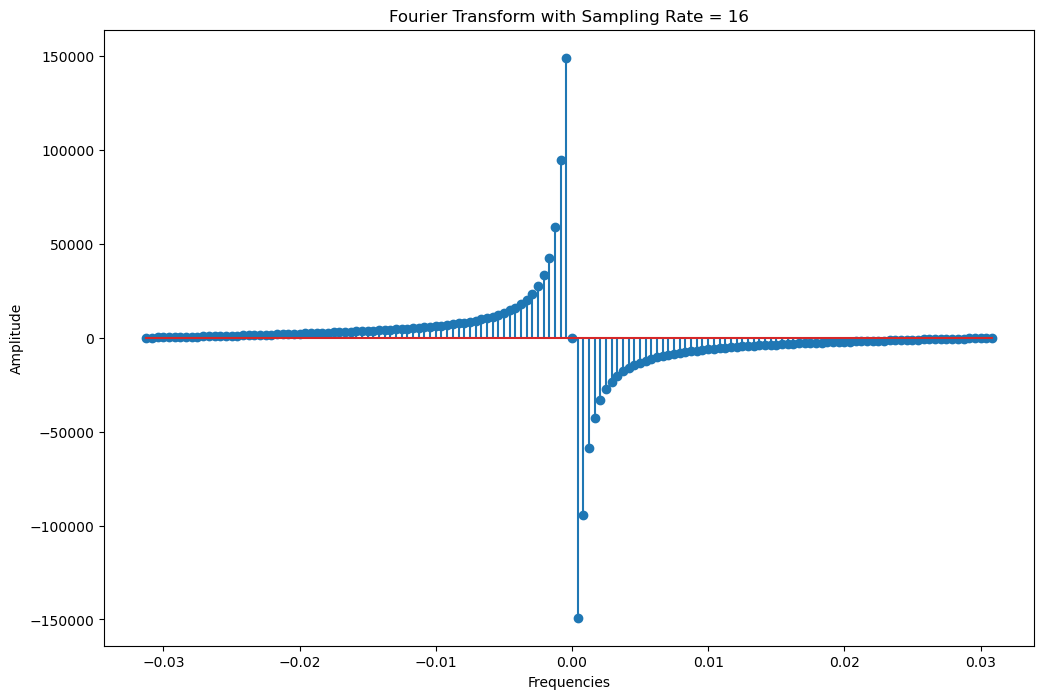

In [71]:
fourier = np.fft.fft(yf)

samp_f = 16
freq = np.fft.fftfreq(len(yf), d=samp_f)
plt.figure(figsize=(12,8))
plt.stem(freq, fourier.imag)
#plt.ylim(0,200000)
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
plt.title('Fourier Transform with Sampling Rate = 16')
plt.xlim()

In [34]:
import filter_self
filter_self = il.reload(filter_self)

y = sat[3]['interpd_edens'].values
t = sat[3]['sat_time']
x = sat[3]['glat'].values

print(t[-1].values, t[0].values)
print(t[-1].values - t[0].values)
print('Length of array ', len(t))

sample = int((time[-1]-time[0]).total_seconds())/len(t)
print(sample)

yf1 = filter_self.filt_filt(y, sample,percent='False')

plt.plot(yf1)
plt.show()

plt.plot(yf-yf1)
plt.show()


2013-03-17T16:00:11.000000000 2013-03-17T15:57:42.000000000
149000000000 nanoseconds
Length of array  150
1189.9933333333333


ZeroDivisionError: float division by zero

### Using fitting on sat1 only for time being

In [11]:
import filter_self


filter_self = il.reload(filter_self)

y = sat[3]['interpd_edens'].values
t = sat[3]['sat_time']
x = sat[3]['glat'].values

print(t[-1].values, t[0].values)
print(t[-1].values - t[0].values)

name, yf = filter_self.best_filters(x, y)

2013-03-17T16:08:38.000000000 2013-03-17T15:38:24.000000000
1814000000000 nanoseconds


['Savgol Filter', 'Polynomial Fitting', 'Chebyshev Fitting', 'Rolling Mean', 'LOWESS Fit']


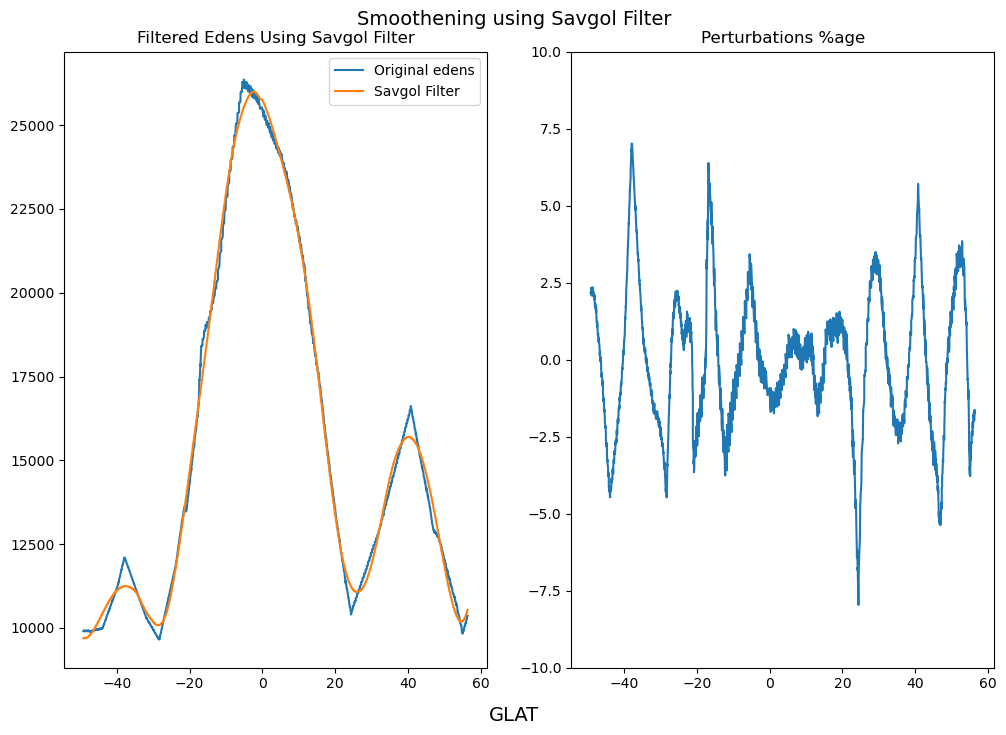

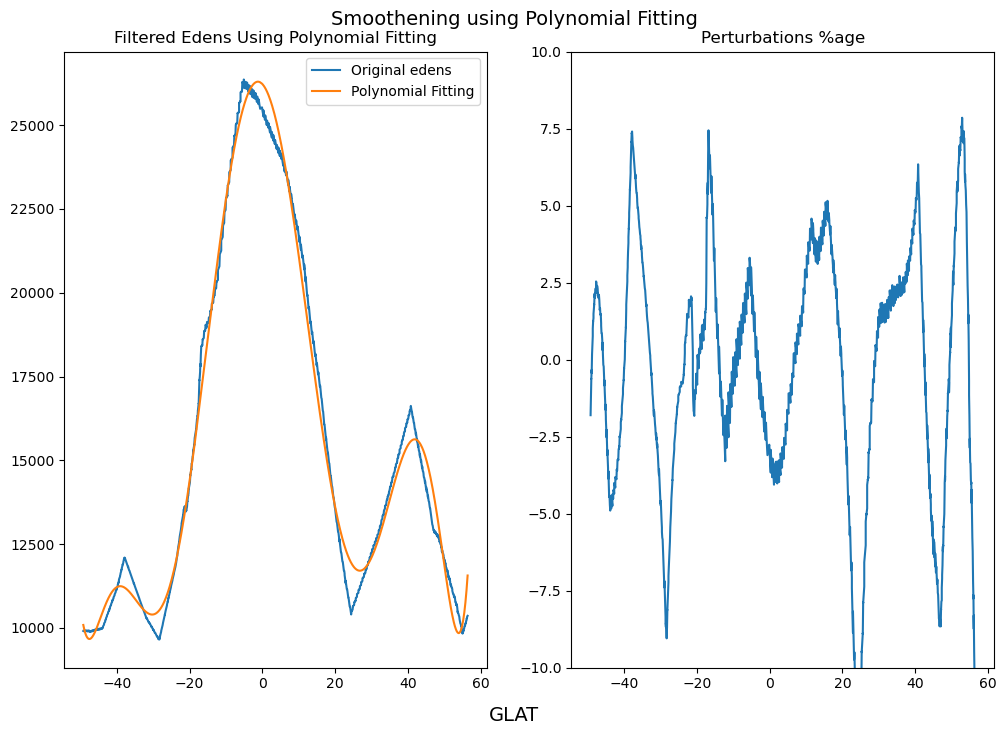

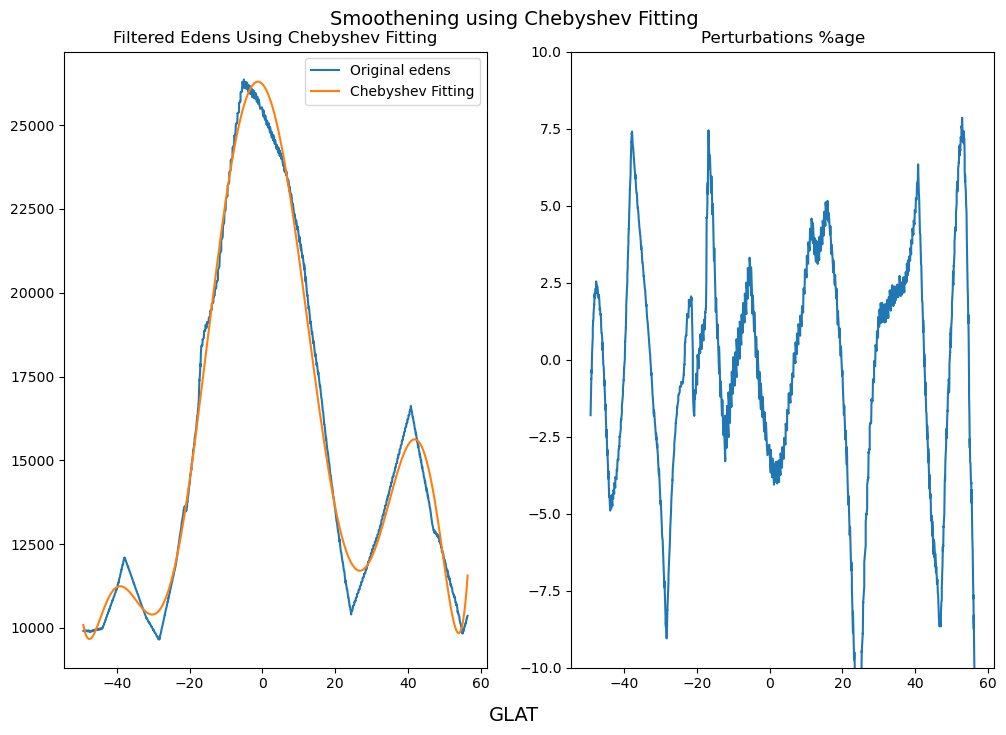

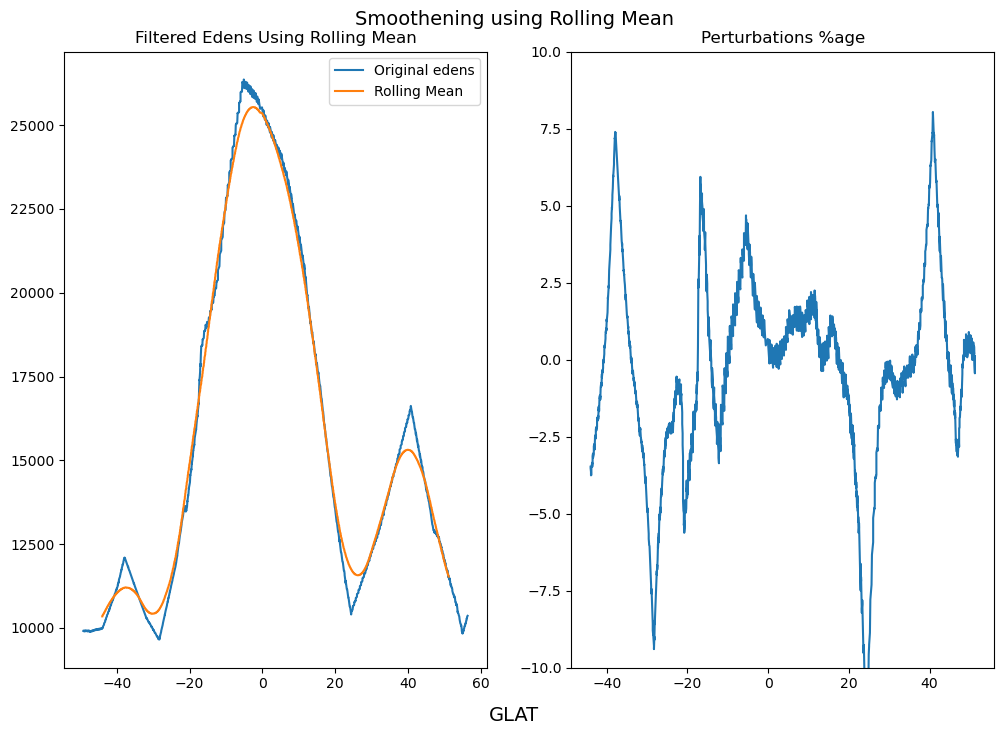

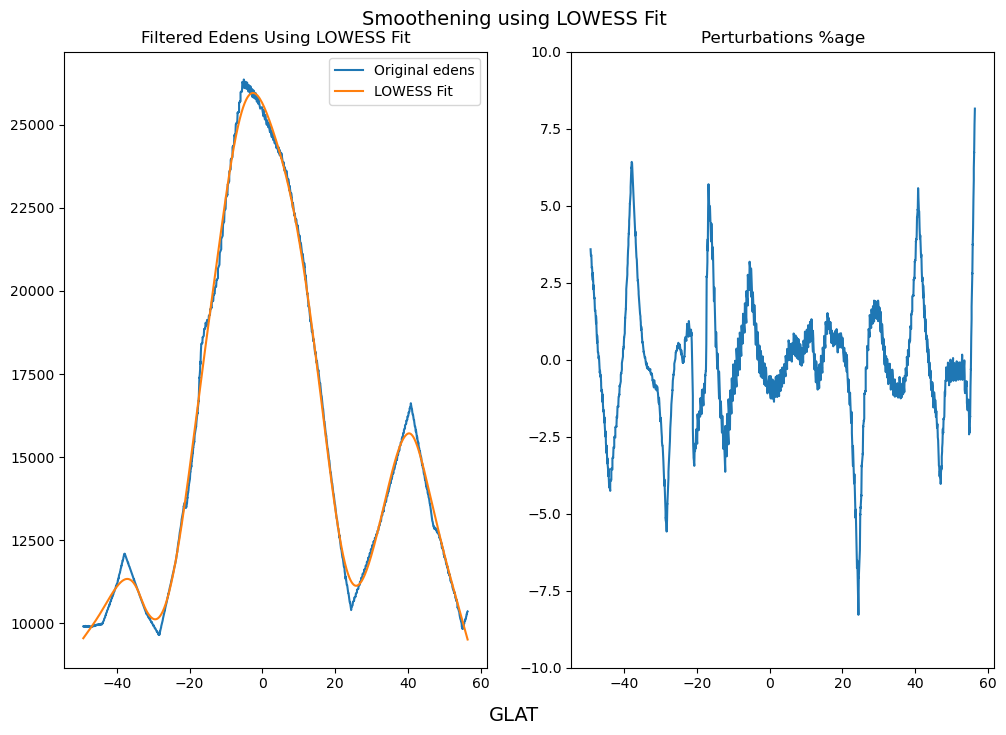

In [12]:

print(name)
#print(yf)

perturb =  np.zeros(x.shape)

for f, n in zip(yf, name):

    perturb = 100*(y-f)/y
    
    fig, axs = plt.subplots(1,2, figsize=(12,8))
    axs[0].plot(x, y, label='Original edens')
    axs[0].plot(x, f, label=n)
    axs[0].set_title('Filtered Edens Using ' + n)
    axs[0].legend()
    
    axs[1].plot(x, perturb)
    axs[1].set_title('Perturbations %age')
    axs[1].set_ylim(-10,10)
    fig.text(0.5, 0.05, 'GLAT', ha='center', va='center', fontsize=14)
    fig.text(0.5, 0.92, 'Smoothening using ' + n, ha='center', va='center', fontsize=14)


(-0.034373284851811195, 0.03433898188803513)

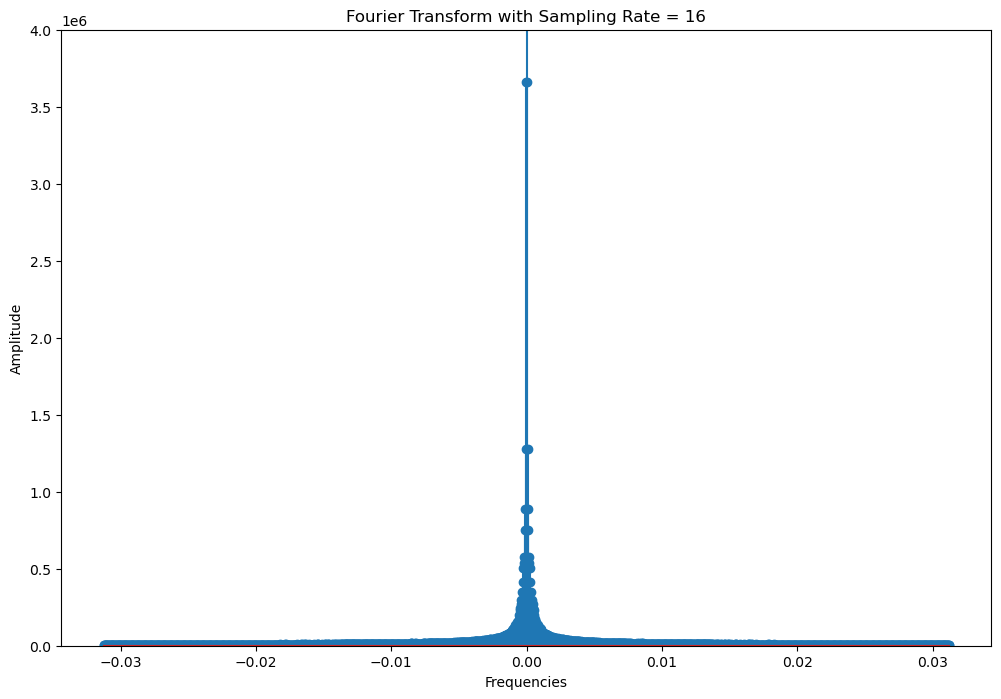

In [131]:
fourier = np.fft.fft(y)

samp_f = 16
freq = np.fft.fftfreq(len(y), d=samp_f)
plt.figure(figsize=(12,8))
plt.stem(freq, np.abs(fourier))
plt.ylim(0,4000000)
plt.xlabel('Frequencies')
plt.ylabel('Amplitude')
plt.title('Fourier Transform with Sampling Rate = 16')
plt.xlim()

In [16]:

'''


# filter_self = il.reload(filter_self)


# from scipy.signal import order_filter, wiener, savgol_filter, hilbert

y = sat1['interp_edens'].values
x = sat1['glat'].values
print(len(y))

num = int(input('Enter the index for filter: '))
name = ['Order_filter', 'Wiener', 'Savgol_filter', 'Hilbert', 'Polyfit', 'Chebyshev', 'Rolling mean']
window = int(input('Degree or Window Size: '))

yf = np.zeros(len(y))

if num == 0:
    # window = 50
    yf = order_filter(y, np.ones(101), rank=window)

elif num == 1:
    # window = 180
    yf = wiener(y,window)

elif num == 2:
    # window = 500
    yf = savgol_filter(y, window, 4) # best results at 4

elif num == 3:
    # window = 500
    
    yy = hilbert(y)
    envelope = np.abs(yy)
    ins_phase = np.unwrap(np.angle(yy))

    ins_phase2 = wiener(ins_phase,window)
    reconstruct = envelope*np.exp(1j*ins_phase)

    yf = np.real(reconstruct)
    
    plt.figure(figsize = (12,8))
    plt.plot(ins_phase)
    plt.plot(ins_phase2)
    plt.show()

elif num == 4:
    
    # window = 10
    yf = filter_self.polyfitting(window, x, y)

elif num == 5:

    # window = 10
    c = Chebyshev.fit(x, y, window)
    yf = c(x)
    print(yf)
    
elif num == 6:

    # window = 50
    yf1 = np.convolve(y, np.ones(window)/window, mode='valid')
    yf = np.zeros(len(y))
    for i in range(len(y)):
        if i-1 < window:
            yf[i] = np.NaN
        
        else:
            yf[i] = yf1[i-window]
    
    print(len(yf))
    #yf = sat1.rolling(on='interp_edens', time=window, center=True).mean().dropna()


perturb = np.zeros(sat1['glat'].shape)

for i in range(len(perturb)):
    perturb[i] = 100*(y[i]-yf[i])/y[i]

fig, axs = plt.subplots(1,2, figsize=(12,8))
axs[0].plot(sat1['glat'], y, label='orig')
axs[0].plot(sat1['glat'], yf, label='filt')
axs[0].set_title('Filtered Edens with Degree/Window ' + str(window))
axs[0].legend()

axs[1].plot(sat1['glat'], perturb)
axs[1].set_title('Perturbations %age')
axs[1].set_ylim(-10,10)
fig.text(0.5, 0.05, 'GLAT', ha='center', va='center', fontsize=14)
fig.text(0.5, 0.92, 'Smoothening using ' + name[num], ha='center', va='center', fontsize=14)

''';

100%|█████████████████████████████████████████████| 6/6 [00:31<00:00,  5.26s/it]


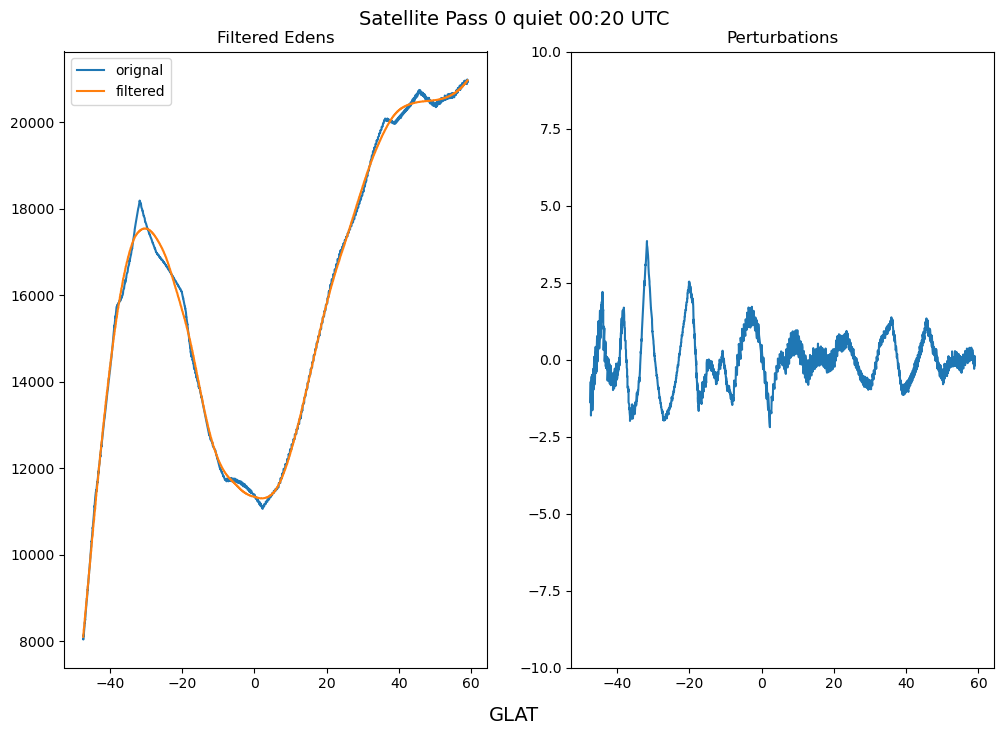

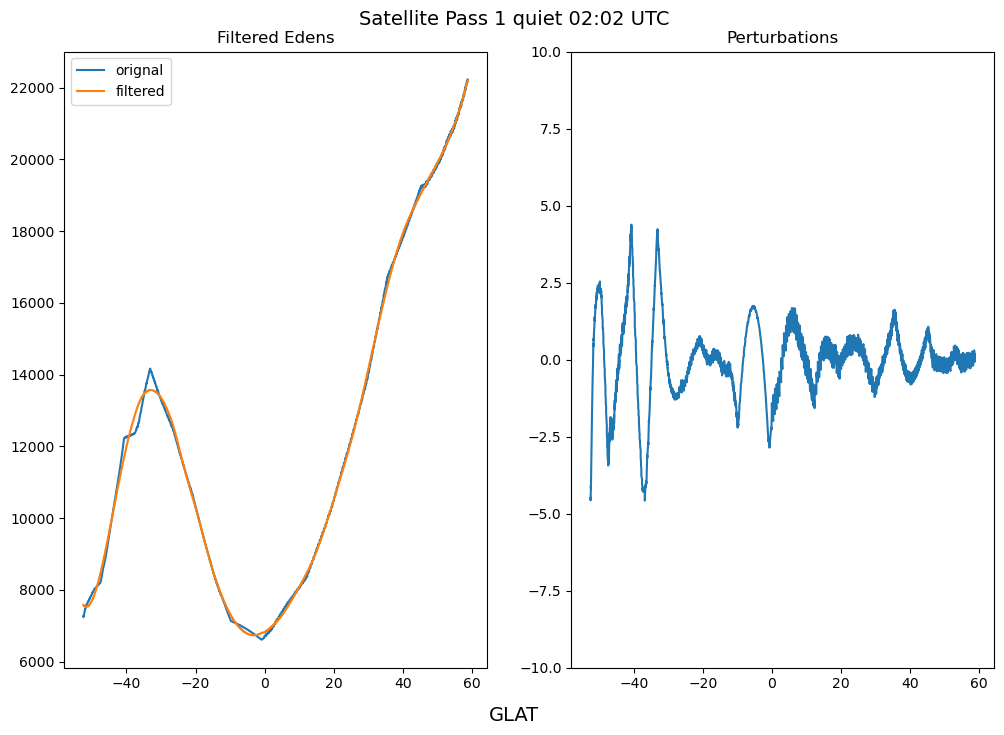

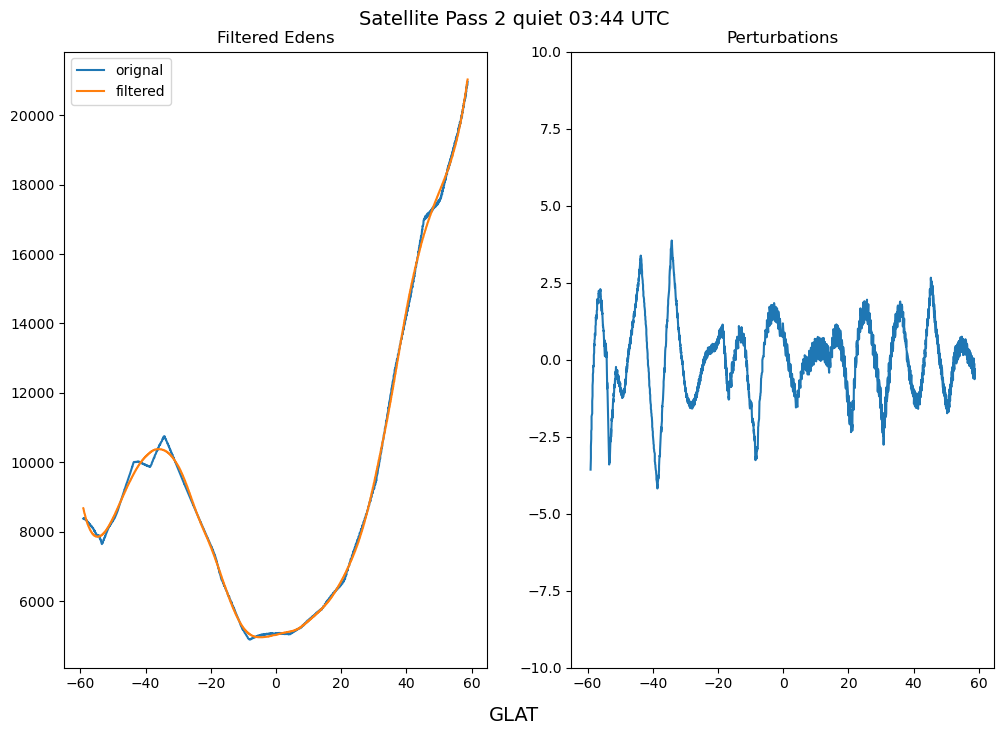

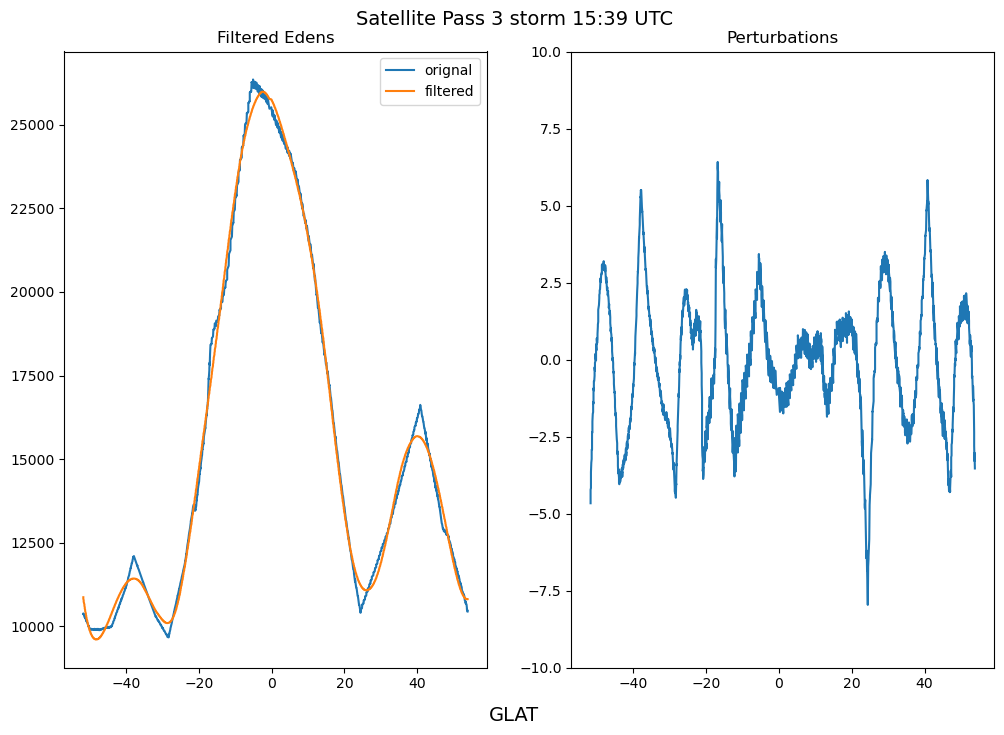

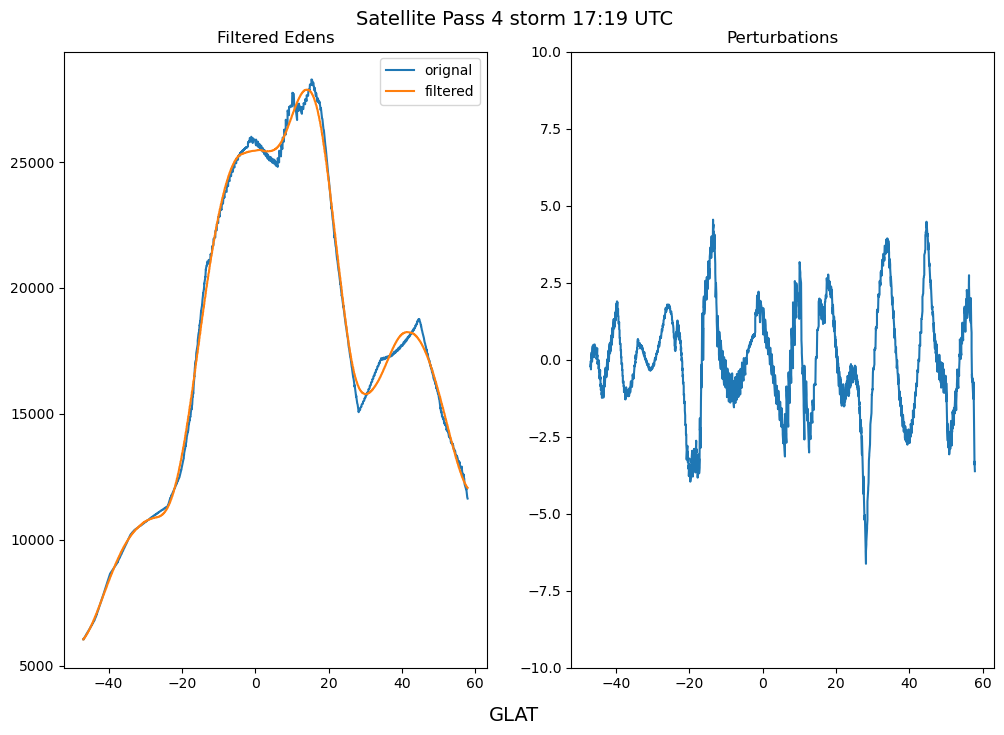

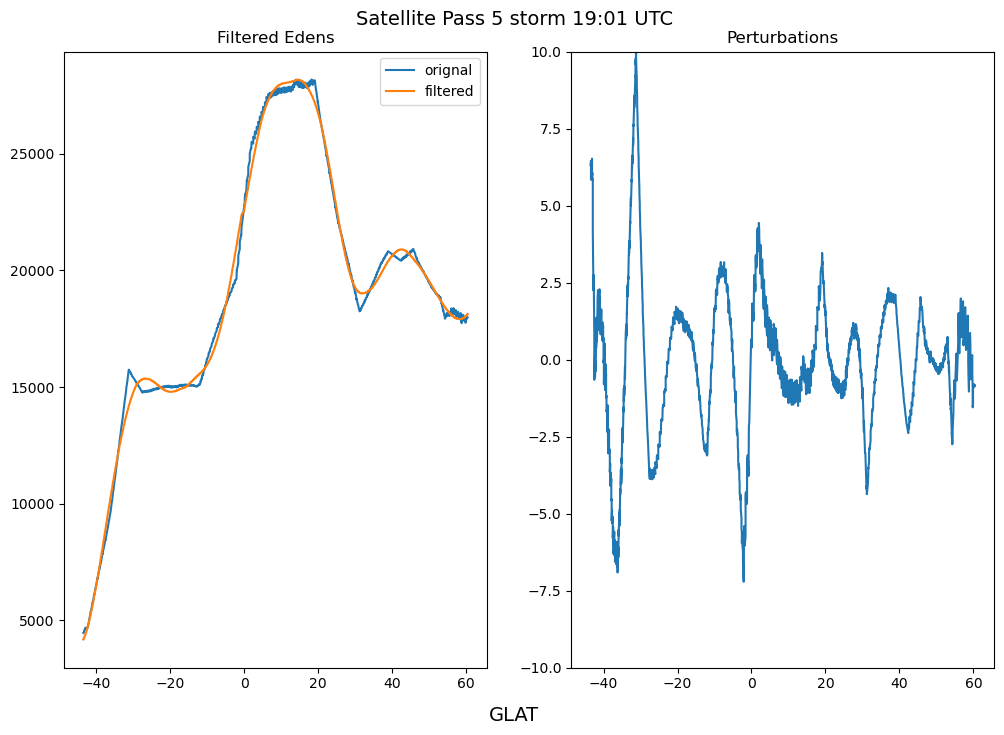

In [7]:
n = 0
label = ['quiet 00:20 UTC', 'quiet 02:02 UTC', 'quiet 03:44 UTC', 'storm 15:39 UTC', 'storm 17:19 UTC', 'storm 19:01 UTC']

for s in tqdm(sat):
    y = s['interp_edens']
    x = s['glat']
    
    filter = savgol_filter(y, 500, 4)
    perturbations = np.zeros(len(y))
    
    for i in range(len(y)):
        perturbations[i] = 100*(y[i] - filter[i])/y[i]
    
    #s['filt_edens'] = ('sat_step', filter)
    #s['perturb'] = ('sat_step', perturbations)

    fig, axs = plt.subplots(1,2, figasize=(12,8))
    axs[0].plot(s['glat'], y, label='orignal')
    axs[0].plot(s['glat'], filter, label='filtered')
    axs[0].set_title('Filtered Edens')
    axs[0].legend()
    axs[1].plot(s['glat'], perturbations)
    axs[1].set_title('Perturbations %age')
    axs[1].set_ylim(-10,10)
    plt.title('Perturbations')
    fig.text(0.5, 0.05, 'GLAT', ha='center', va='center', fontsize=14)
    fig.text(0.5, 0.92, 'Satellite Pass ' + str(n) + ' ' + label[n], ha='center', va='center', fontsize=14)

    n += 1



# Trying Smoothening or Filtering on Complete Satellite Data

100%|████████████████████████████████████| 86101/86101 [04:03<00:00, 353.26it/s]


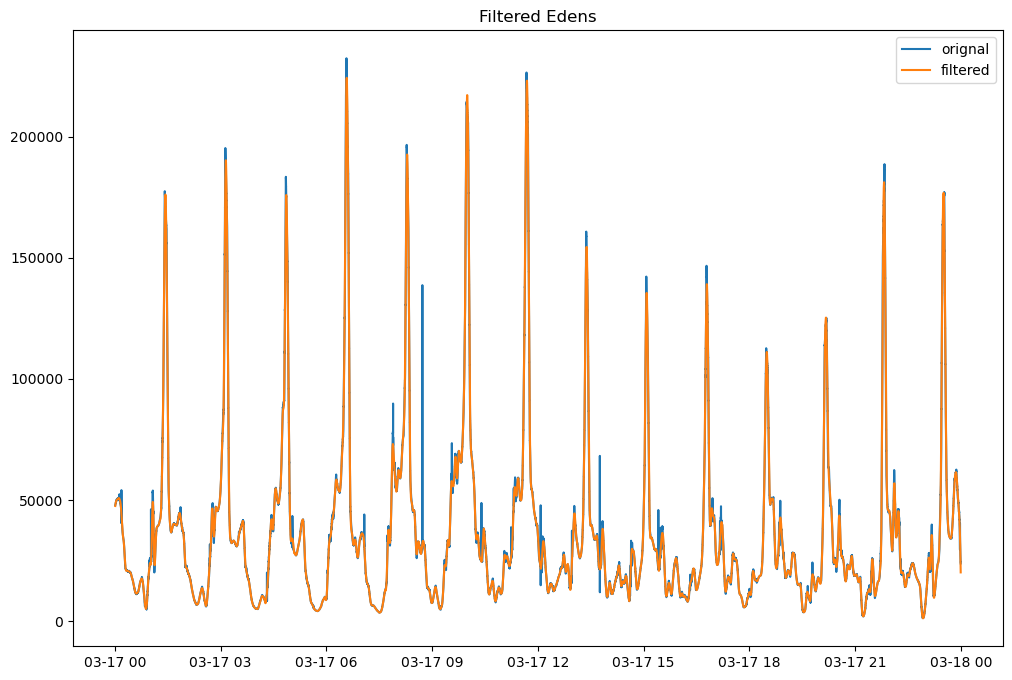

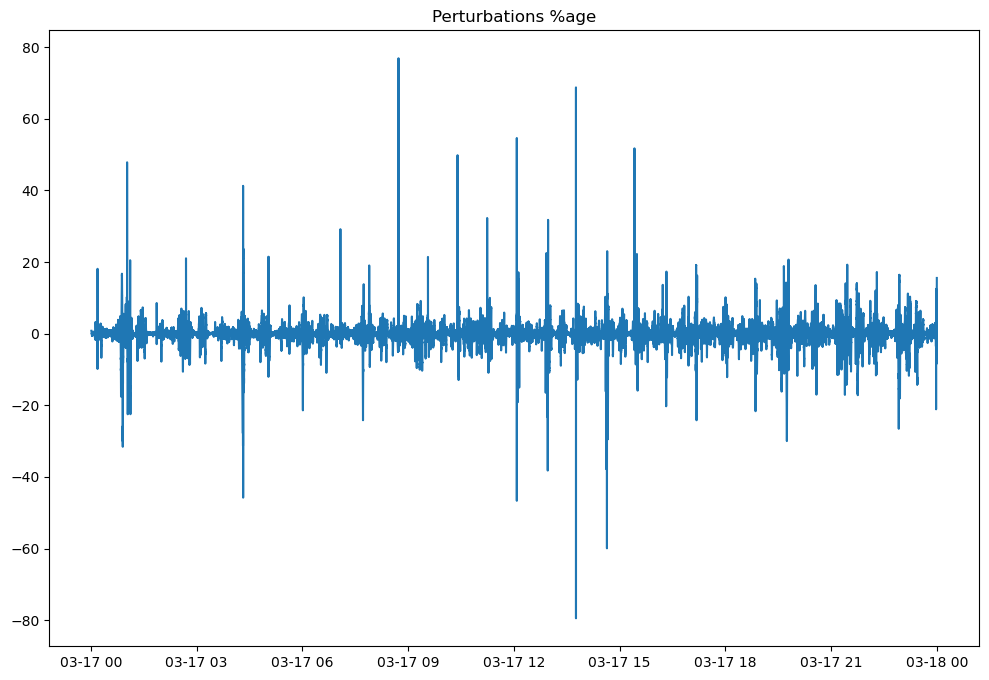

In [51]:

sat_c = xr.open_dataset('/time_interpolated_data/parallel_data/sat_data.nc')

y = sat_c['interp_edens']
x = sat_c['glat']

filter = savgol_filter(y, 500, 4)
perturbations = np.zeros(len(y))

for i in tqdm(range(len(y))):
    perturbations[i] = 100*(y[i] - filter[i])/y[i]

plt.figure(figsize=(12,8))
plt.plot(sat_c['sat_time'], y, label='orignal')
plt.plot(sat_c['sat_time'], filter, label='filtered')
plt.title('Filtered Edens')
plt.legend()
plt.ylim(0,25000)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(sat_c['sat_time'], perturbations)
plt.title('Perturbations %age')
plt.show()

# Center the filters